Machine learning model for predicting fuel consumption.

Hyperparameter tuning and training of various linear and tree-based algorithms.

Comparison of optimally tuned models.

Perform model tuning and validation on splits of 'train' set (years 2019, 2020).

Perform final model testing on 'test' set (year 2021).

Input(s): 
- df_ml_[variant]_train.csv
- df_ml_[variant]_test.csv
- ML_FC_Exploration_all_feature_names_desc.csv (for correlation plot)

Output(s): 
- Git Untracked Data:
    - Model dataframes with fitted estimators after certain steps
        - _mdl_df_base.pkl
        - _mdl_df_best.pkl
        - _mdl_df_kf.pkl
        - _mdl_df_compare.pkl
- Git Tracked Data:
    - parameters: _params.csv
    - stats comparisons for residual and fuel consumption: e.g. _best_fc.csv
    - feature importance rankings: _FI.csv    

## Preamble

In [136]:
import os
import string
import sys
# from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor
sys.path.append("../code/.")
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
# from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    # RandomizedSearchCV,
    # cross_val_score,
    # cross_validate,
    # train_test_split,
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
# from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, matthews_corrcoef, make_scorer #, PredictionErrorDisplay
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, LeaveOneOut, LeavePOut, KFold, RepeatedKFold
import seaborn as sns
import pickle # for saving models
from sklearn.inspection import permutation_importance # for permutation feature importance
import time #for timing


## Global Settings

In [137]:
test_criteria = {
    "test2021" : ('year', '2021'),
    "test2020" : ('year', '2020')
}

In [140]:
feature_set = 'cal_fc' # feature set to use (defined herein)
fast_only = True # if True, only run models that are fast

In [141]:
# Default to log transform target
y_transformer_func = np.log1p
y_transformer_inverse_func = np.expm1

test_set_criterion = "test2021"
no_transform = False # if True, do not transform target or predictors
tol_type = 'abs' # 'rel' or 'abs' tolerance type for subsetting 'valid' data based on distance discrepancy

outlier_threshold = np.Inf #3 # number of standard deviations from the mean to consider a point an outlier

test_exp = "df_ml_raw['" + test_criteria[test_set_criterion][0] + "'].isin([" + test_criteria[test_set_criterion][1] + "])"
train_exp = "~" + test_exp

# if no_transform:
#     y_transformer_func = None
#     y_transformer_inverse_func = None

validation_stats = {
    # my name: function, printing name, greater_is_better
    'r2': (r2_score, 'R²', True),
    # 'corr': (corr2, 'Correlation'), # doesn't work for cv
    'mse': (mean_squared_error, 'MSE', False),
    'mae': (mean_absolute_error, 'MAE', False),
    'mape': (mean_absolute_percentage_error, 'MAPE', False),
    # 'corr': (matthews_corrcoef, 'corr') # doesn't work!
} 

cv_folds = 5
cv_scoring = 'r2'

eval_types_dict = {
    'gridsearch': cv_folds,
    'lpo': LeavePOut(2),
    'kfold': 10,
    'repkfold': RepeatedKFold(n_repeats=3, n_splits=10, random_state=2652124)
}
train_eval_type = 'repkfold' #'gridsearch' # one of keys of eval_types_dict

max_cores = 6

sns.set_theme(
    context='paper',
    palette='colorblind', # deep, dark, bright, colorblind
    font_scale=1.4
    ) 
sns.set_style('whitegrid',
    {'axes.grid': False})
plt.rcParams["font.family"] = "Bitstream Vera Sans"
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.frameon'] = False

datapath = 'Machine Learning/data/'
readdatapath = 'src/tracked_data/'
trackeddatapath = 'Machine Learning/tracked_data/'
plotpath = 'Machine Learning/plots/'

fileprefix = 'ML_FC_features_F' + feature_set + '_' + test_set_criterion + '_' #'_rel_' #+ '_nofilter_' 
if no_transform:
    fileprefix += 'linear_'
if fast_only:
    fileprefix += 'fast_'
model_df_filename = 'mdl_df'

start_time = time.time()

param_vars = [
    'y_transformer_func',
    'y_transformer_inverse_func',
    'tol_type',
    'outlier_threshold',
    'feature_set',
    'no_transform',
    'test_exp',
    'train_exp',
    'cv_folds',
    'cv_scoring',
    'train_eval_type',
    'eval_types_dict',
    'datapath',
    'trackeddatapath',
    'plotpath',
    'fileprefix',
    'model_df_filename']

# Load feature sets and check if specificed one is valid
feature_sets_df = pd.read_csv(trackeddatapath + 'ML_FC_variants_generated.csv')
if (feature_set not in variants) & (feature_set not in list(feature_sets_df['variable'])):
    sys.exit('Invalid feature set')

# safeguard against overwriting if slow to run
if ~fast_only & os.path.exists(trackeddatapath + fileprefix + 'params.csv'):
    sys.exit('File already exists. Delete params csv file to overwrite all related data.')


pd.DataFrame(
    [(i, globals()[i]) for i in param_vars],
    columns = ['parameter', 'value']
    ).to_csv(
        trackeddatapath + fileprefix + 'params.csv',
        index = False)

print(f"Started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}")

Started at: 2024-04-25 18:02:43


### Functions

In [142]:
def col_search(searchkey):
    """
    Search for column names containing a given string and print summary statistics. (case insensitive)
    """
    colname_matches = [col for col in df_ml.columns if searchkey.lower() in col.lower()]
    if len(colname_matches) > 0:
        print(colname_matches)
        df_ml[colname_matches].describe()
        for col in colname_matches:
            if df_ml[col].nunique() <= 10:
                print(col)
                print(df_ml[colname_matches].value_counts())
    else:
        print('No matches found')

def plot_45deg_line(x, y, xylinelabel):
    """
    Create a two-way plot with a 45-degree line.
    """
    upper = 1.01*max(x.max(), y.max())
    lower = 0.99*min(x.min(), y.min())
    x0 = np.linspace(lower, upper, 100)
    plt.plot(x0, x0, alpha=0.8, color = 'black', linestyle='dashed', label=xylinelabel)

def two_way_plot(x, y, data=None, hue=None, alpha=0.5, title=None, xlabel=None, ylabel=None, legend=True, legend_title=None, line_labels=False, regline=False, savepath=None):
    """
    Create a two-way plot with a regression line.
    """
    plt.figure(figsize=(5, 5), dpi=300)
    sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=alpha)
    if line_labels:
        reglinelabel='Linear regression'
        xylinelabel='x=y'
    else:
        reglinelabel=None
        xylinelabel=None

    if data is None:
        plot_45deg_line(x, y, xylinelabel)
    else:
        plot_45deg_line(data[x], data[y], xylinelabel)
    
    if regline:
        sns.regplot(
            data=data, x=x, y=y, 
            scatter=False,
            line_kws={'linestyle':'dotted'},
            label=reglinelabel,
            color='black')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(
            title=legend_title,
            bbox_to_anchor=(1.05, 0.5),
            loc='center left')
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

def plot_45deg_line_new(x, y, ax):
    """
    Create a two-way plot with a 45-degree line.
    """
    upper = max(x.max(), y.max()) + 0.1
    lower = min(x.min(), y.min()) - 0.1
    x0 = np.linspace(lower, upper, 100)
    ax.plot(x0, x0, color='black', label='x=y')

def two_way_plot_new(x, y, data=None, hue=None, alpha=0.5, title=None, xlabel=None, ylabel=None, legend_title=None, regline=False, savepath=None):
    """
    Create a two-way plot with a regression line.
    """
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
    sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=alpha, ax=ax)
    if regline:
        sns.regplot(data=data, x=x, y=y, scatter=False, line_kws={'linestyle':'dashed'}, label='regression line', color='red', ax=ax)
    if data is None:
        plot_45deg_line_new(x, y, ax=ax)
    else:
        plot_45deg_line_new(data[x], data[y], ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=legend_title)
    if savepath:
        plt.savefig(savepath)
    plt.show()
    return ax

# def make_estimator_default(scaling, mdlclass):
#     if scaling:
#         estimator = make_pipeline(preprocessor_scaling, mdlclass)
#     elif ~scaling:
#         estimator = make_pipeline(preprocessor_noscaling, mdlclass)
#     return estimator

def make_estimator(scaling, classname, y_transformer_func=None, y_transformer_inverse_func=None, params=None):
    if params is None:
        if classname == 'LinearRegression':
            estimator = make_pipeline(preprocessor_noscaling_drop, globals()[classname]())
        elif scaling:
            estimator = make_pipeline(preprocessor_scaling, globals()[classname]())
        elif ~scaling:
            estimator = make_pipeline(preprocessor_noscaling, globals()[classname]())
    else:
        if scaling:
            estimator = make_pipeline(preprocessor_scaling, globals()[classname](**params))
        elif ~scaling:
            estimator = make_pipeline(preprocessor_noscaling, globals()[classname](**params))

    estimator = TransformedTargetRegressor(regressor=estimator,
                                           func=y_transformer_func, inverse_func=y_transformer_inverse_func)
    return estimator
    
# def MAE(y_true, y_pred):
#     """
#     Calculate mean absolute error.
#     """
#     return np.mean(np.abs(y_true - y_pred))
                   
# def MAPE(y_true, y_pred):
#     """
#     Calculate mean absolute percentage error.
#     """
#     return np.mean(np.abs((y_true - y_pred) / y_true))

# def corr2(x, y):
#     """
#     Calculate the correlation coefficient.
#     """
#     return np.corrcoef(x, y)[0, 1]

def calculate_stats(y_true, y_pred, data=None, stats_dict=None):
    """
    Create a dictionary of statistics for a model.
    """
    if data is not None:
        y_true = data[y_true]
        y_pred = data[y_pred]

    values_dict = {}
    names_dict = {}
    for stat in stats_dict.keys():
        values_dict[stat] = stats_dict[stat][0](y_true, y_pred)
        names_dict[stat] = stats_dict[stat][1]
    return {'stats' : values_dict, 'names' : names_dict}    

def create_legend_title(stats_dict):
    """
    Create a legend title for a plot based on a dictionary of statistics.
    """
    legend_title = ''
    for key in stats_dict['stats']:
        legend_title += f"{stats_dict['names'][key]}: {round(stats_dict['stats'][key],3)}\n"
    return legend_title

def cross_validate_stats(X, y, estimator, cv, validation_stats, max_cores):
    cv_scores = cross_validate(
        estimator,
        X, y,
        cv=cv,
        scoring={key: make_scorer(stat[0], greater_is_better=stat[2]) for key, stat in validation_stats.items()},
        # scoring=make_scorer(r2_score, greater_is_better=True),
        n_jobs=max_cores)

    means = [np.mean(value) for key, value in cv_scores.items() if key.startswith('test_')]
    # take negative where approriate because cross_validate returns negatives if ~greater_is_better
    means = [means[index]*(1 if value[2] else -1) for index, value in enumerate(validation_stats.values())]
    sds = [np.std(value) for key, value in cv_scores.items() if key.startswith('test_')]
    return {"means": dict(zip(validation_stats.keys(), means)),
            "sds": dict(zip(validation_stats.keys(), sds)),
            "names": {keys: values[1] for keys, values in validation_stats.items()}}

def format_cv_results(grid_search):
    """
    Format the results of a grid search as a pandas DataFrame.
    """
    cv_results = pd.DataFrame(grid_search.cv_results_)[['param_gradientboostingregressor__learning_rate', 'param_gradientboostingregressor__max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
    # shorten column names
    cv_results.columns = cv_results.columns.str.removeprefix('param_gradientboostingregressor__')
    cv_results.columns = cv_results.columns.str.replace('_score', '_' + cv_scoring)
    print(f"Model: { grid_search.estimator.named_steps['gradientboostingregressor'].__class__.__name__ }")
    return cv_results

# def model_comparison_table(stats_to_compare, params=None):
#     """
#     Create a pandas DataFrame of statistics for multiple models.
#     Args:
#         stats_to_compare: dictionary of tuples of statistics dictionaries and models
#     Returns:
#         pandas DataFrame
#     """
#     for key, value in stats_to_compare.items():
#         value[0]['stats']['model'] = key
#         if params is not None:
#             for param in params:
#                 try:
#                     value[0]['stats'][param] = value[1][-1].get_params()[param]
#                 except:
#                     value[0]['stats'][param] = np.nan

#     compare_df = pd.DataFrame([value[0]['stats'] for key, value in stats_to_compare.items()]).set_index('model')
#     return compare_df

def tribble(columns, *data):
    return pd.DataFrame(
        data=list(zip(*[iter(data)]*len(columns))),
        columns=columns
    )

def model_stats_comparison_table(stats_col, params_col, estimator_col, mdl_df, stat_key='stats'):
    """
    Create a pandas DataFrame of statistics for multiple models.
    Args: 
        stats_col: name of column containing statistics
        estimator_col: name of column containing fitted estimators
    Returns:
        pandas DataFrame
    """

    compare_df = mdl_df.loc[:, [stats_col, estimator_col, params_col, 'class_name']]
    
    compare_df[stats_col] = compare_df[stats_col].apply(lambda x: x[stat_key])

    for key in compare_df[stats_col].iloc[0].keys():
        compare_df[key] = compare_df[stats_col].apply(lambda x: x[key])

    compare_df['params'] = compare_df.apply(lambda row: extract_filter_params(row, estimator_col, params_col), axis=1)

    return compare_df.drop([stats_col, estimator_col, params_col], axis=1)

def extract_filter_params(row, estimator_col, params_col_mask): 
    """ 
    Extract and filter the parameters to the ones in params_col and drop parameter name prefix.
    Args:
        row: pandas DataFrame row
        estimator_col: name of column containing fitted estimators
        params_col_mask: name of column containing parameters to keep (should be without model name prefix)
    """
    params = row[estimator_col].regressor.named_steps[row['class_name'].lower()].get_params()
    if row[params_col_mask] is None:
        return None
    else:
        return {k.replace(row['class_name'].lower() + '__', ''): v for k, v in params.items() if k in row[params_col_mask].keys()}

# def filter_params(row, params_col, params_col_mask): 
#     """ 
#     Filter the parameters to the ones in params_col and drop parameter name prefix.
#     """
#     if row[params_col_mask] is None:
#         return None
#     else:
#         return {k.replace(row['class_name'].lower() + '__', ''): v for k, v in row[params_col].items() if k in row[params_col_mask].keys()}
    
# def loo_evaluation(estimator):
#     """
#     Performs leave-one-out evaluation and returns the predicted residuals.
#     """
#     loo_prediction = np.zeros(len(y))

#     for train_index, val_index in loo.split(X):
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]
#         estimator.fit(X_train, y_train)
#         loo_prediction[val_index] = estimator.predict(X_val)
    
#     return loo_prediction

# def kfold_evaluation(estimator, name):
#     """
#     Performs k-fold evaluation and returns the predicted residuals.
#     """
#     print(f"Starting evaluating {name} at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}")
#     kf_prediction = np.zeros(len(y))

#     for train_index, val_index in kf.split(X):
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]
#         estimator.fit(X_train, y_train)
#         kf_prediction[val_index] = estimator.predict(X_val)
    
#     return kf_prediction

def FI_plot(FI, model_name):
    FI_df = pd.DataFrame(FI.importances, index = features).assign(mean=lambda df: df.mean(axis=1)).sort_values('mean')
    plt.figure(figsize=(5, 5), dpi=300)
    plt.boxplot(
        FI_df.drop(columns='mean').T,
        vert=False,
        labels=np.array(FI_df.index),
    )
    plt.title('Permutation Importances: ' + model_name)
    plt.savefig(plotpath + fileprefix + 'FI_perm_' + model_name + '.png')
    plt.show()

def agg_prediction_by_year(estimator, df):
    years = np.sort(df['year'].unique())
    predictions = [estimator.predict(df.loc[df['year']==year]).sum() for year in years]
    return pd.DataFrame(predictions, index=pd.Index(years, name='year'), columns=['predict_fc_total'])

def group_permutation_scores(y_true, X, est, feature_names=[], stats_dict=None, n_repeats=5, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    scores = []

    for i in range(n_repeats):
        X_permuted = X.copy()
        for feature in feature_names:
            X_permuted[feature] = np.random.permutation(X_permuted[feature].values)
        y_predict = est.predict(X_permuted)
        perm_stats = calculate_stats(y_true, y_predict, stats_dict=stats_dict)['stats']
        scores.append(perm_stats.values())

    return pd.DataFrame(scores, columns=stats_dict.keys())


def plot_group_permutation_scores(feature_groups_df, group_col, df_ml_test, est, stats_dict, stat='r2', model_name=None):
    importances = pd.DataFrame()
    for group in feature_groups_df[group_col].unique():
        group_features = feature_groups_df.loc[feature_groups_df[group_col] == group]['variable']
        group_scores = group_permutation_scores(
            df_ml_test['report_fc'],
            df_ml_test,
            # mdl_df.loc['lasso', 'best_estimator'],
            est,
            feature_names = group_features,
            stats_dict=stats_dict)
        group_scores['group'] = group
        importances = pd.concat([importances, group_scores])

    sns.boxplot(importances, y='group', x=stat, showfliers=False)
    plt.title(model_name)
    # plt.xlim(0,)
    plt.show()
    
def plot_incremental_group_perm(feature_groups_df, feature_groups_ordered, df_ml_test, est, stats_dict, stat='r2', model_name=None):
    importances = pd.DataFrame()
    for i in range(1, len(feature_groups_ordered)+1):
        groups = feature_groups_ordered[i:]
        # print(groups)
        group_features = feature_groups_df.loc[feature_groups_df['group'].isin(groups)]['variable']
        group_scores = group_permutation_scores(df_ml_test['report_fc'],
                                df_ml_test,
                                est,
                                feature_names = group_features,
                                stats_dict=stats_dict)
        group_scores['group'] = ', '.join(feature_groups_ordered[~np.isin(feature_groups_ordered, groups)])
        importances = pd.concat([importances, group_scores])

    sns.boxplot(importances, y='group', x=stat, showfliers=False)
    plt.title(model_name)
    plt.ylabel('Non-permuted Categories')
    plt.xlabel(stat)
    if stat=='r2':
        plt.xlim(0,1)
    plt.show()

## Data Validation and Preprocessing

### Load

In [143]:
df_ml_raw = pd.read_csv(readdatapath + "df_ml_" + tol_type + "_all.csv", low_memory=False)
df_ml_raw.groupby('year').count()

,CVN,IMO.Number,Name,mmsi,Ex.Name,Flag.State,Operator,Owner,Group.Owner,Built.Date,...,total_jump_distance,missing_frac_sea,age,residual,log_report_fc,log_cal_fc,distance_difference,distance_difference_rel,jump_distance_frac,within_tol_jumps
year,,,,,,,,,,,,,,,,,,,,,
2019,506,506,506,506,201,506,428,506,506,506,...,506,506,506,506,506,506,506,506,506,506
2020,627,627,627,627,240,627,536,627,627,627,...,627,627,627,627,627,627,627,627,627,627
2021,644,644,644,644,281,644,555,644,644,644,...,644,644,644,644,644,644,644,644,644,644


In [144]:
# df_ml = pd.read_csv(readdatapath + "df_ml_" + tol_type + "_train.csv", low_memory=False)
df_ml = df_ml_raw.loc[eval(train_exp)]

df_ml.groupby('year').count()

,CVN,IMO.Number,Name,mmsi,Ex.Name,Flag.State,Operator,Owner,Group.Owner,Built.Date,...,total_jump_distance,missing_frac_sea,age,residual,log_report_fc,log_cal_fc,distance_difference,distance_difference_rel,jump_distance_frac,within_tol_jumps
year,,,,,,,,,,,,,,,,,,,,,
2019,506,506,506,506,201,506,428,506,506,506,...,506,506,506,506,506,506,506,506,506,506
2020,627,627,627,627,240,627,536,627,627,627,...,627,627,627,627,627,627,627,627,627,627


In [145]:

# for nicer colors when plotting
df_ml = df_ml.sort_values('year')
df_ml['year_str'] = df_ml['year'].astype(str) 


# Create OECD variable
df_ml['cubic_meter'] = df_ml['Beam.Mld..m.']*df_ml['Depth.Moulded..m.']*df_ml['LOA..m.']

### Stats


In [146]:
raw_mean = df_ml['residual'].mean()
raw_std = df_ml['residual'].std()
print(f'Raw Data: \n observations: {len(df_ml)} \n target mean: {raw_mean} \n target sd: {raw_std}')

stats_raw = calculate_stats('report_fc', 'cal_fc', df_ml, validation_stats)

Raw Data: 
 observations: 1133 
 target mean: 0.0396685011926016 
 target sd: 0.26834272543109344


### Outliers

In [147]:
df_ml['outlier'] = ~df_ml['residual'].between(
    raw_mean - outlier_threshold * raw_std,
    raw_mean + outlier_threshold * raw_std,
    inclusive='neither')

### Filter out outliers 

In [148]:
df_ml = df_ml.loc[~df_ml['outlier']]
print(f'Filtered Data: \n observations: {len(df_ml)} \n target mean: {df_ml.residual.mean()} \n target sd: {df_ml.residual.std()}')

Filtered Data: 
 observations: 1133 
 target mean: 0.0396685011926016 
 target sd: 0.26834272543109344


## Feature Selection


### Manually Selected Features


In [149]:
# Define category ordering
ordinal_encoding_cat_dict = {
    'Size.Category' : ['Capesize', 'Panamax', 'Handymax', 'Handysize']
}

### Assign feature set

In [150]:
if feature_set in variants:
    features = feature_sets_df.loc[feature_sets_df[feature_set], 'variable'].to_list()
else:
    features = [feature_set]

features_df = pd.read_csv('Machine Learning/tables/ML_FC_Exploration_all_feature_names_desc.csv')

ordinal_cols = features_df.loc[features_df['variable'].isin(features) & (features_df['type'] == 'ordinal'), 'variable'].to_list()
indicator_cols = features_df.loc[features_df['variable'].isin(features) & (features_df['type'] == 'indicator'), 'variable'].to_list()
cat_cols = features_df.loc[features_df['variable'].isin(features) & (features_df['type'] == 'cat'), 'variable'].to_list()
numnonneg_cols = features_df.loc[features_df['variable'].isin(features) & (features_df['type'] == 'numnonneg'), 'variable'].to_list()
numneg_cols = features_df.loc[features_df['variable'].isin(features) & (features_df['type'] == 'numneg'), 'variable'].to_list()
pd.DataFrame(features, columns=['variable']).to_csv(trackeddatapath + fileprefix + 'features.csv', index=False)

### Set variables for ml training

In [151]:
y = df_ml['report_fc'] #df_ml['log_report_fc']

# need cal_fc in dataset for calculating engineering stats
if 'cal_fc' in features:
    X = df_ml[features]
else:
    X = df_ml[features + ['cal_fc']]

#### Collinearity

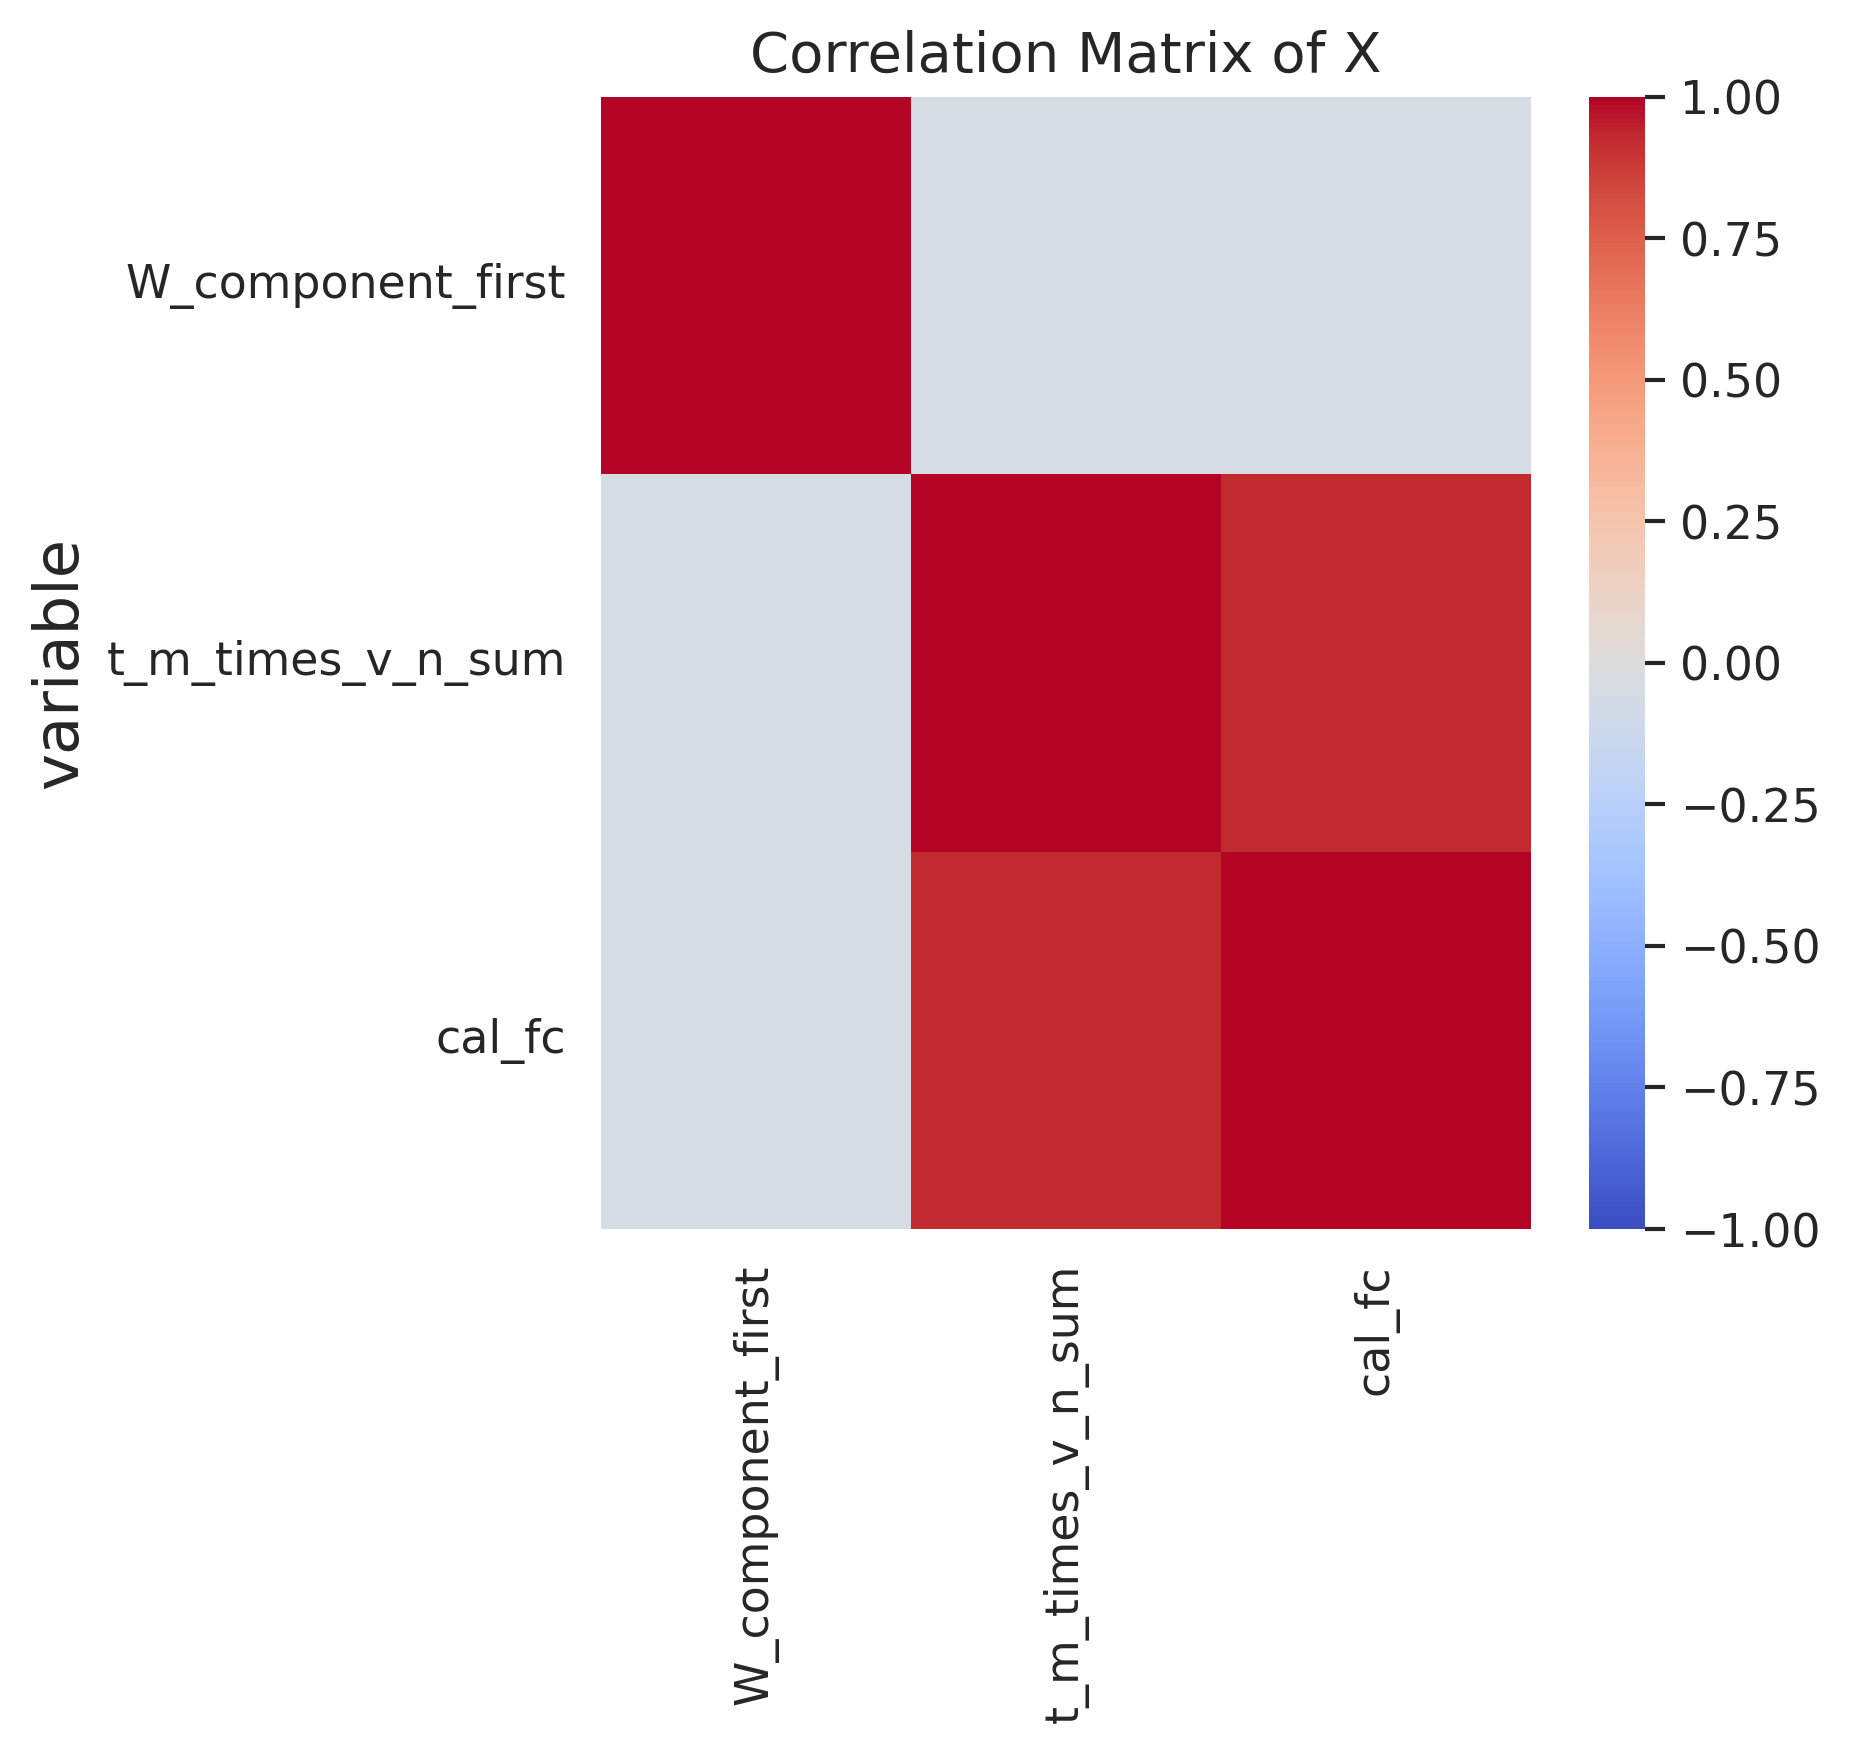

In [152]:
groups_df = features_df[['variable', 'group']]
corr_mx = (
    X[numneg_cols + numnonneg_cols]
    .corr()

)

corr_mx = (
    corr_mx
    .merge(groups_df[['variable', 'group']], left_index=True, right_on='variable')
    .sort_values('group')
    .drop(columns='group')
    .set_index('variable'))
corr_mx = corr_mx[corr_mx.index]

plt.figure(figsize=(5, 5), dpi=300)
sns.heatmap(corr_mx, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of X')
plt.show()


## Models

In [153]:
mdl_df = tribble(
    ['model',    'class_name',                 'name',                    'type',  'scaling', 'fast'],
     'gb',       'GradientBoostingRegressor',  'Gradient Boosting',       'tree',   False,    True,
     'linear',   'LinearRegression',           'Linear Regression',       'linear', False,    True,
     'lasso',    'Lasso',                      'Lasso',                   'linear', True,     True,
     'ridge',    'Ridge',                      'Ridge',                   'linear', True,     True,
     'rf',       'RandomForestRegressor',      'Random Forest',           'tree',   False,    False,
     'cb',       'CatBoostRegressor',          'Cat Boost',               'tree',   False,    False
    #  'lgbm',     'LGBMRegressor',              'Light Gradient Boosting', 'tree',   False,
    #  'xgb',      'XGBRegressor',           'tree',   False,
).set_index('model')
if fast_only:
    mdl_df = mdl_df[mdl_df['fast']]

mdl_df.to_csv(trackeddatapath + fileprefix + 'mdl_settings.csv')
mdl_df

,class_name,name,type,scaling,fast
model,,,,,
gb,GradientBoostingRegressor,Gradient Boosting,tree,False,True
linear,LinearRegression,Linear Regression,linear,False,True
lasso,Lasso,Lasso,linear,True,True
ridge,Ridge,Ridge,linear,True,True


## Pre-processing

### Imputation, Tranformation, Scaling

In [154]:
median_imputer = SimpleImputer(strategy='median')
missing_string = 'missing'
impute_as_missing = SimpleImputer(strategy='constant', fill_value=missing_string)

# setting categories manually is necessary for prediction in using the kfold evaluation loop
ind_to_encode = [X[col].fillna('missing').unique() for col in indicator_cols]
ind_encoder = OneHotEncoder(categories=ind_to_encode)
ind_encoder_nonregularized = OneHotEncoder(categories=ind_to_encode, drop='first')

cat_to_encode = [X[col].fillna('missing').unique() for col in cat_cols]
cat_encoder = OneHotEncoder(categories=cat_to_encode)
cat_encoder_nonregularized = OneHotEncoder(categories=cat_to_encode, drop='first')

log_transformer = FunctionTransformer(np.log1p, validate=True)
ordinal_transformer = make_pipeline(OrdinalEncoder(categories=[values for values in ordinal_encoding_cat_dict.values()]))

scaler = StandardScaler()

# Pipelines for numerical
impute = Pipeline(steps=[('impute', median_imputer)])

impute_transform = Pipeline(steps=[
    ('impute', median_imputer),
    ('transform', log_transformer)])

impute_scale = Pipeline(steps=[
    ('impute', median_imputer),
    ('scale', scaler)])

impute_transform_scale = Pipeline(steps=[
    ('impute', median_imputer),
    ('transform', log_transformer),
    ('scale', scaler)])

# Pipelines for indicator
ind_impute_encode = Pipeline(steps=[
    ('impute', impute_as_missing),
    ('encode', ind_encoder)])

ind_impute_encode_nonregularized = Pipeline(steps=[
    ('impute', impute_as_missing),
    ('encode', ind_encoder_nonregularized)])

# Pipelines for categorical
cat_impute_encode = Pipeline(steps=[
    ('impute', impute_as_missing),
    ('encode', cat_encoder)])

cat_impute_encode_nonregularized = Pipeline(
    steps=[('impute', impute_as_missing),
           ('encode', cat_encoder_nonregularized)])

### Column Transformers

In [155]:
# re-define pipelines if no_transform variant
if no_transform:
    impute_transform_scale = impute_scale
    impute_transform = impute

# scaling not required for tree-based models
preprocessor_scaling = ColumnTransformer(
    transformers=[
        ('numeric_nonneg', impute_transform_scale, numnonneg_cols),
        ('numeric_neg', impute_scale, numneg_cols),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('indicator', ind_impute_encode, indicator_cols),
        ('categorical', cat_impute_encode, cat_cols)
        ])

preprocessor_noscaling = ColumnTransformer(
    transformers=[
        ('numeric_nonneg', impute_transform, numnonneg_cols), # or with scaling
        ('numeric_neg', impute, numneg_cols), # or with scaling
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('indicator', ind_impute_encode, indicator_cols),
        ('categorical', cat_impute_encode, cat_cols)
        ])

# drops one category of onehot encoded categorical variables (only used for linreg)
preprocessor_noscaling_drop = ColumnTransformer(
    transformers=[
        ('numeric_nonneg', impute_transform, numnonneg_cols), # or with scaling
        ('numeric_neg', impute, numneg_cols), # or with scaling
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('indicator', ind_impute_encode_nonregularized, indicator_cols),
        ('categorical', cat_impute_encode_nonregularized, cat_cols)
        ])

### Base Parameters

In [156]:
mdl_base_dict = {
    'gb': {
        'n_estimators': 2000,
        'learning_rate': 0.1,
        'max_depth': 3,
        'max_features': 'sqrt',
        'min_samples_leaf': 20,
        'loss': 'squared_error',
        'min_samples_split': 20,
        'warm_start': True
    },
    'linear': {},
    'lasso': {
        'alpha': 0.01,
    },
    'ridge': {
        'alpha': 0.01,
    },
    'rf': {
        'n_estimators': 200,
        'max_depth': 10,
        # 'max_features': 'sqrt',
        # 'min_samples_leaf': 20,
        # 'min_samples_split': 20,
    },
    'cb': {
        'verbose': 0
    },
    'lgbm': {
        'verbose': 1
    },
    'xgb': {} 
}


mdl_df['base_params'] = [mdl_base_dict.get(mdl) for mdl in mdl_df.index]

In [157]:
df_ml[df_ml['cal_fc']==max(df_ml['cal_fc'])]

,CVN,IMO.Number,Name,mmsi,Ex.Name,Flag.State,Operator,Owner,Group.Owner,Built.Date,...,residual,log_report_fc,log_cal_fc,distance_difference,distance_difference_rel,jump_distance_frac,within_tol_jumps,year_str,cubic_meter,outlier
1438,16271539.0,9727974,Flag Mette,249262000.0,NaN,Malta,Golden Union,Golden Union,Golden Union,2016-09-01,...,-0.202084,8.600534,8.802618,42.76461,0.00089,0.0,True,2019,148120.177,False


## Estimators

In [158]:
mdl_df['estimator'] = mdl_df.apply(
    lambda row: make_estimator(
        row['scaling'],
        row['class_name'],
        y_transformer_func=y_transformer_func,
        y_transformer_inverse_func=y_transformer_inverse_func,
        params=row['base_params']),
    axis=1)

## Test base parameters

In [159]:
for model in mdl_df.index:
    mdl_df.loc[model, 'estimator'].fit(X, y)

#### Fuel Consumption

In [160]:
mdl_df['base_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        y,
        row['estimator'].predict(X),
        stats_dict=validation_stats),
    axis=1)

compare_base_fc_df = model_stats_comparison_table('base_fc_stats', 'base_params', 'estimator', mdl_df).sort_values('r2', ascending=False)
compare_base_fc_df.to_csv(trackeddatapath + fileprefix + 'base_fc.csv')
compare_base_fc_df

,class_name,r2,mse,mae,mape,params
model,,,,,,
gb,GradientBoostingRegressor,0.960772,32692.519472,115.477225,0.091162,"{'learning_rate': 0.1, 'loss': 'squared_error'..."
linear,LinearRegression,0.875180,104024.741287,201.914333,0.163508,{}
ridge,Ridge,0.875179,104025.882565,201.914230,0.163508,{'alpha': 0.01}
lasso,Lasso,0.868895,109262.923251,205.006330,0.165251,{'alpha': 0.01}


In [161]:
mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_base.pkl')

In [162]:
print(f"Test base parameters complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

Test base parameters complete at 2024-04-25 18:02:46, after 0.0 minutes



## Hyperparameter Tuning: 5-fold CV, Grid Search

In [163]:
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_base.pkl')

### Define search grids

In [164]:
mdl_gs_dict = {
    'gb': {
        'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6]
    },
    'linear': {},
    'lasso': {
        'alpha': [5e-3, 1e-2, 0.1, 1, 10, 100, 1000],
    },
    'ridge': {
        'alpha': [5e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000, 100000],
    },
    'rf': {
        'n_estimators': [200, 700, 1000],
        'max_depth': [10, 30, 50],
        # 'max_features': ['sqrt'],
        # 'min_samples_leaf': [20],
        # 'min_samples_split': [20],
    },
    'cb': {
        'learning_rate' : [0.01, 0.05, 0.1],
        'depth': [6, 8 ,10],
        # 'iterations': [10, 50, 500],
        'l2_leaf_reg': [1, 7, 15]
    },
    'lgbm': {
        'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'learning_rate': [0.005, 0.01, 0.1, 0.2, 0.3],
        'num_iterations': [10, 50, 100, 500, 1000, 5000, 10000],
        'max_bin': [255, 300, 500, 1000],
        'boosting' : ['gbdt', 'dart'],
    },
    # 'xgb': 
}


mdl_df['gs_params'] = [mdl_gs_dict.get(mdl) for mdl in mdl_df.index]

In [165]:
# for quicker testing
# mdl_gs_dict = {
#     'gb': {
#         'learning_rate': [0.01],
#         'max_depth': [3, 4]
#     },
#     'linear': {},
#     'lasso': {
#         'alpha': [0.1],
#     },
#     'ridge': {
#         'alpha': [0.1],
#     },
#     'rf': {
#         'n_estimators': [200],
#         'max_depth': [10],
#         # 'max_features': ['sqrt'],
#         # 'min_samples_leaf': [20],
#         # 'min_samples_split': [20],
#     },
#     'cb': {
#         'depth': [6, 8],
#         'iterations': [30],
#         'l2_leaf_reg': [7]
#     },
#     'lgbm': {
#         'num_leaves': [50],
#         'learning_rate': [0.01, 0.1],
#         'num_iterations': [100],
#         'max_bin': [500],
#         'boosting' : ['gbdt', 'dart']
#     },
#     # 'xgb': 
# }


# mdl_df['gs_params'] = [mdl_gs_dict.get(mdl) for mdl in mdl_df.index]

In [166]:
# add model class_name prefix to parameter names
mdl_df['gs_params_prefix'] = mdl_df.apply(lambda row: {'regressor__' + row['class_name'].lower() + '__' + k: v for k, v in row['gs_params'].items()}, axis=1)
mdl_df[['gs_params', 'gs_params_prefix']]

,gs_params,gs_params_prefix
model,,
gb,"{'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2...",{'regressor__gradientboostingregressor__learni...
linear,{},{}
lasso,"{'alpha': [0.005, 0.01, 0.1, 1, 10, 100, 1000]}","{'regressor__lasso__alpha': [0.005, 0.01, 0.1,..."
ridge,"{'alpha': [0.005, 0.01, 0.1, 1, 10, 100, 1000,...","{'regressor__ridge__alpha': [0.005, 0.01, 0.1,..."


### Fit grid search

In [167]:
mdl_df['grid_search'] = mdl_df.apply(
    lambda row: GridSearchCV(
        row['estimator'],
        row['gs_params_prefix'],
        cv=cv_folds,
        scoring=cv_scoring,
        n_jobs=max_cores,
        verbose=1),
        axis=1)

for model in mdl_df.index:
    mdl_df.loc[model, 'grid_search'].fit(X, y)
    

mdl_df['best_estimator'] = mdl_df.apply(lambda row: row['grid_search'].best_estimator_, axis=1)
# This estimator is refitted on whole training set

# Column of best parameters chosen from grid search CV (with short names)
mdl_df['best_params'] = mdl_df.apply(lambda row: extract_filter_params(row, 'best_estimator', 'gs_params'), axis=1)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


### CV Results

In [168]:
mdl_df['best_cv_mean_score'] = mdl_df.apply(lambda row: row['grid_search'].cv_results_['mean_test_score'][row['grid_search'].best_index_], axis=1)

mdl_df['best_cv_std_score'] = mdl_df.apply(lambda row: row['grid_search'].cv_results_['std_test_score'][row['grid_search'].best_index_], axis=1)

cv_best_fc = (
    mdl_df.loc[:, ['class_name', 'best_cv_mean_score', 'best_cv_std_score', 'best_params']]
    .sort_values('best_cv_mean_score', ascending=False)
    )
cv_best_fc.to_csv(trackeddatapath + fileprefix + 'best_cv_fc.csv')
cv_best_fc

,class_name,best_cv_mean_score,best_cv_std_score,best_params
model,,,,
gb,GradientBoostingRegressor,0.872844,0.021652,"{'learning_rate': 0.005, 'max_depth': 3}"
linear,LinearRegression,0.872394,0.014242,{}
ridge,Ridge,0.872393,0.014241,{'alpha': 0.005}
lasso,Lasso,0.869460,0.013371,{'alpha': 0.005}


### Best estimator training set stats

In [169]:
mdl_df['best_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        y,
        row['best_estimator'].predict(X),
        stats_dict=validation_stats),
    axis=1)
compare_best_fc_df = model_stats_comparison_table('best_fc_stats', 'best_params', 'best_estimator', mdl_df).sort_values('r2', ascending=False)
compare_best_fc_df.to_csv(trackeddatapath + fileprefix + 'best_train_fc.csv')
compare_best_fc_df

,class_name,r2,mse,mae,mape,params
model,,,,,,
gb,GradientBoostingRegressor,0.910881,74271.699798,174.157107,0.143386,"{'learning_rate': 0.005, 'max_depth': 3}"
linear,LinearRegression,0.875180,104024.741287,201.914333,0.163508,{}
ridge,Ridge,0.875180,104025.311868,201.914282,0.163508,{'alpha': 0.005}
lasso,Lasso,0.872192,106515.517972,203.359202,0.164308,{'alpha': 0.005}


In [170]:
mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_best.pkl')

In [171]:
print(f"Hyperparameter tuning complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

Hyperparameter tuning complete at 2024-04-25 18:03:35, after 0.9 minutes


#### Run time
- takes around 25 minutes total

In [172]:
# processing time (seconds) of best estimators
mdl_df.loc[:, 'grid_search'].apply(lambda x: x.cv_results_['mean_fit_time'][x.cv_results_['rank_test_score'] == 1][0])

model
gb        2.426940
linear    0.009592
lasso     0.012575
ridge     0.012087
Name: grid_search, dtype: float64

## Evaluation of Tuned Models


In [173]:
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_best.pkl')

In [174]:
mdl_df['eval_stats'] = mdl_df.apply(
    lambda row: cross_validate_stats(
        X,
        y,
        row['best_estimator'],
        eval_types_dict[train_eval_type],
        validation_stats,
        max_cores),
    axis=1)

### Stats FC

In [175]:
eval_means_df = model_stats_comparison_table('eval_stats', 'best_params', 'best_estimator', mdl_df, 'means')
eval_sds_df = model_stats_comparison_table('eval_stats', 'best_params', 'best_estimator', mdl_df, 'sds')
compare_eval_df = eval_means_df.join(
    eval_sds_df.drop(columns=['class_name', 'params']),
    lsuffix='_mean',
    rsuffix='_sd').sort_values('r2_mean', ascending=False)
compare_eval_df.to_csv(trackeddatapath + fileprefix + 'eval_fc_stats.csv')
compare_eval_df

,class_name,r2_mean,mse_mean,mae_mean,mape_mean,params,r2_sd,mse_sd,mae_sd,mape_sd
model,,,,,,,,,,
linear,LinearRegression,0.870639,104629.761578,202.649992,0.164363,{},0.032128,28589.964828,23.369796,0.014546
ridge,Ridge,0.870639,104630.364966,202.649941,0.164363,{'alpha': 0.005},0.032127,28590.315235,23.369849,0.014546
gb,GradientBoostingRegressor,0.868434,104473.077104,205.040247,0.171735,"{'learning_rate': 0.005, 'max_depth': 3}",0.035191,21745.436469,19.692850,0.016489
lasso,Lasso,0.867937,107144.765392,204.152229,0.165198,{'alpha': 0.005},0.031268,29413.247400,23.403909,0.014528


In [176]:
mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_eval.pkl')

print(f"Training set evaluation complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

Training set evaluation complete at 2024-04-25 18:03:48, after 1.1 minutes


## Training Set Performance

In [177]:
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_eval.pkl')

### Stats FC

#### Engineering Model

In [178]:
stats_eng = calculate_stats(y, X.cal_fc, stats_dict=validation_stats)
stats_eng_df = pd.DataFrame(stats_eng).drop('names', axis=1).T
stats_eng_df['model'] = 'eng'
stats_eng_df['class_name'] = 'Calculation'
stats_eng_df = stats_eng_df.set_index('model')
stats_eng_df

,r2,mse,mae,mape,class_name
model,,,,,
eng,0.831937,140063.492334,230.979307,0.186442,Calculation


#### ML Models

In [179]:
for model in mdl_df.index:
    mdl_df.loc[model, 'best_estimator'].fit(X, y)

In [180]:
mdl_df['train_prediction'] = mdl_df.apply(lambda row: row['best_estimator'].predict(X), axis=1)
mdl_df['train_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        y,
        row['train_prediction'],
        stats_dict=validation_stats),
    axis=1)
compare_train_fc_df = model_stats_comparison_table('train_fc_stats', 'best_params', 'best_estimator', mdl_df)
compare_train_fc_df = pd.concat([stats_eng_df, compare_train_fc_df], axis=0).sort_values('r2', ascending=False)
compare_train_fc_df.to_csv(trackeddatapath + fileprefix + 'train.csv', index=False)
compare_train_fc_df

,r2,mse,mae,mape,class_name,params
model,,,,,,
gb,0.910363,74703.294876,174.323723,0.143437,GradientBoostingRegressor,"{'learning_rate': 0.005, 'max_depth': 3}"
linear,0.875180,104024.741287,201.914333,0.163508,LinearRegression,{}
ridge,0.875180,104025.311868,201.914282,0.163508,Ridge,{'alpha': 0.005}
lasso,0.872192,106515.517972,203.359202,0.164308,Lasso,{'alpha': 0.005}
eng,0.831937,140063.492334,230.979307,0.186442,Calculation,NaN


### Two-way plot of FC

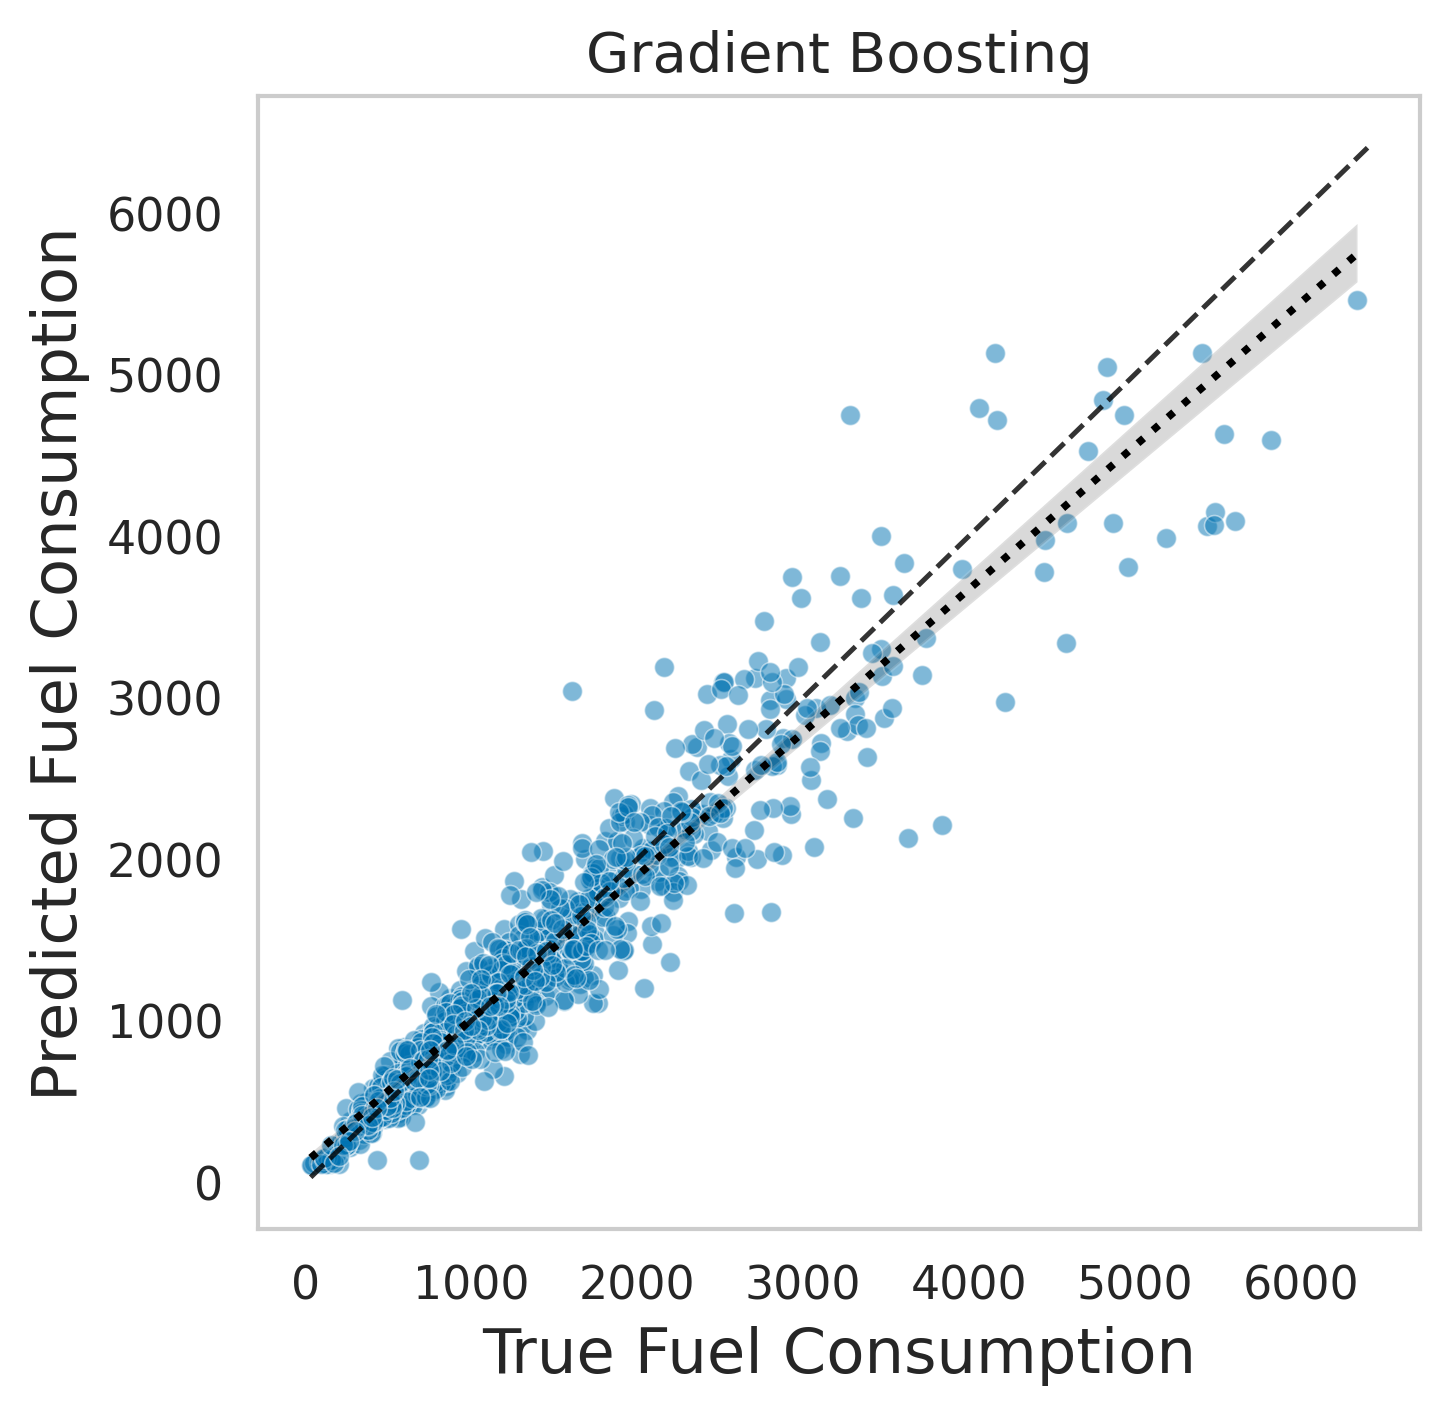

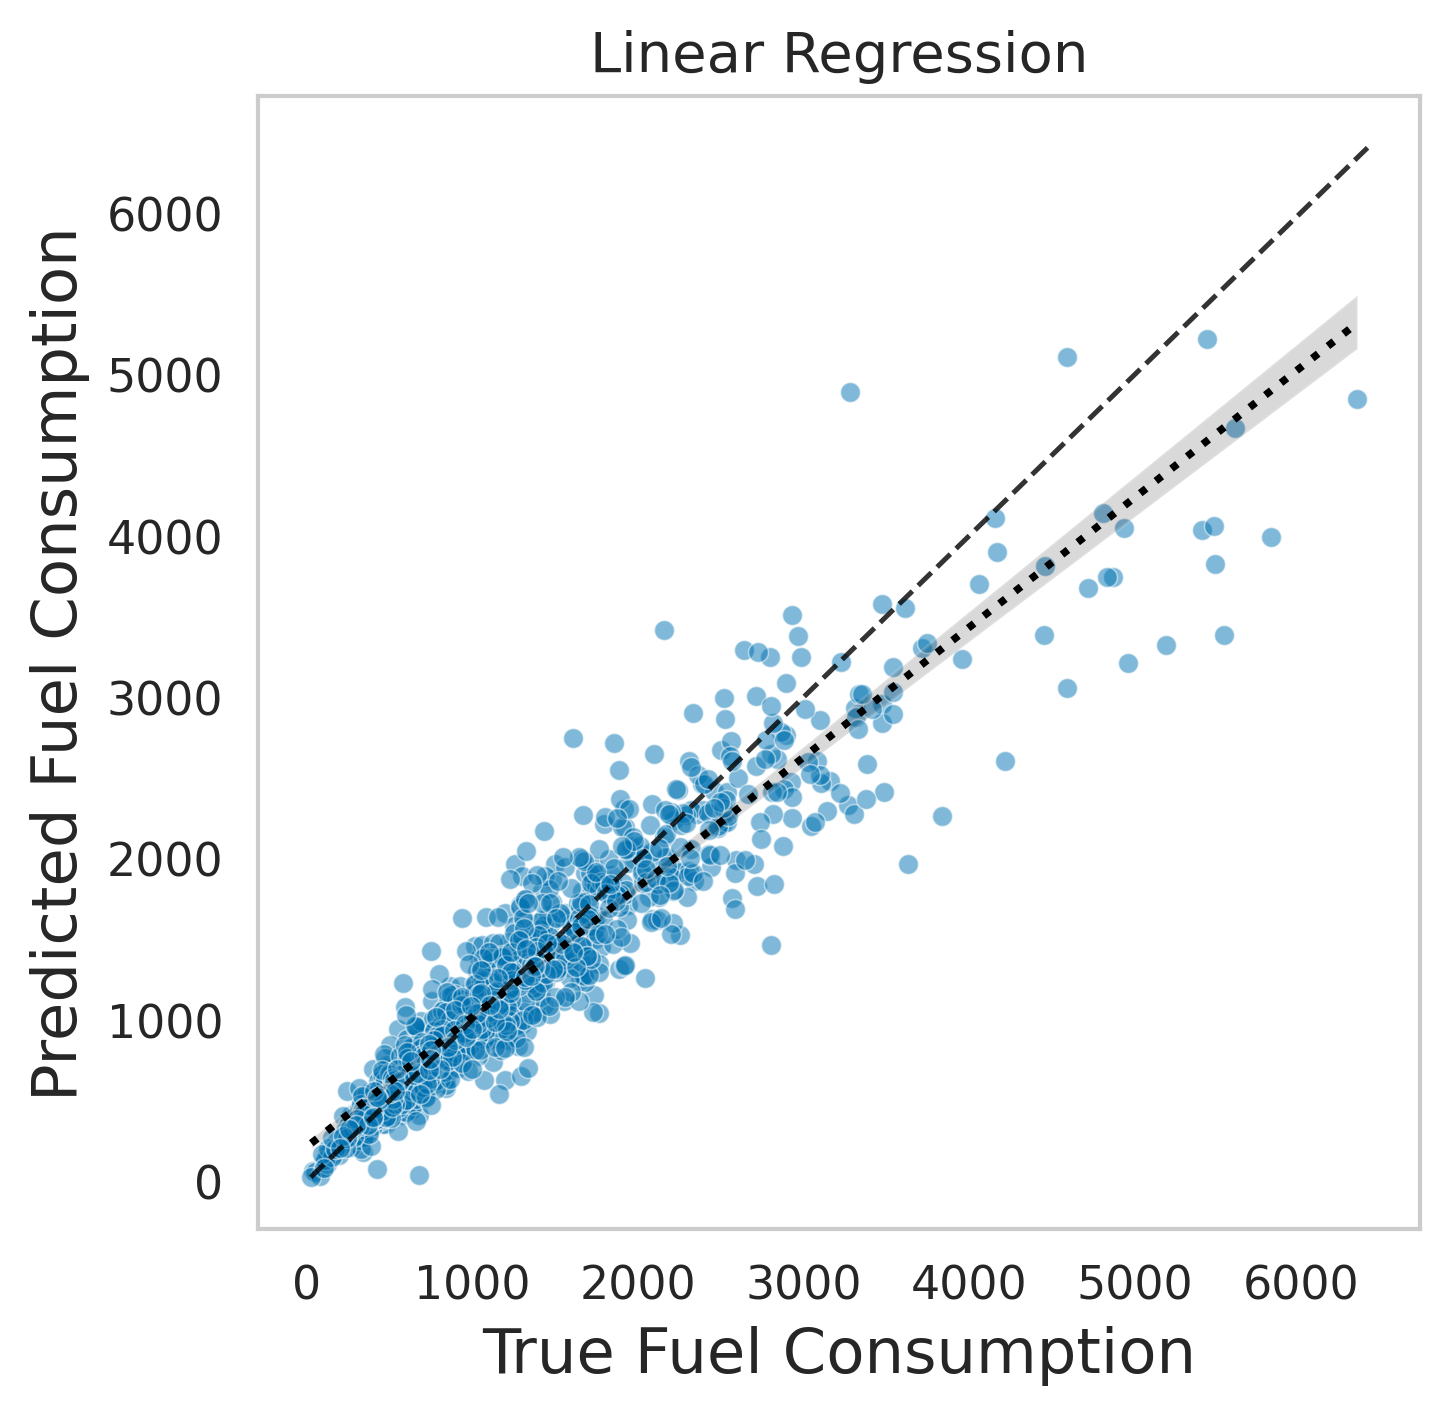

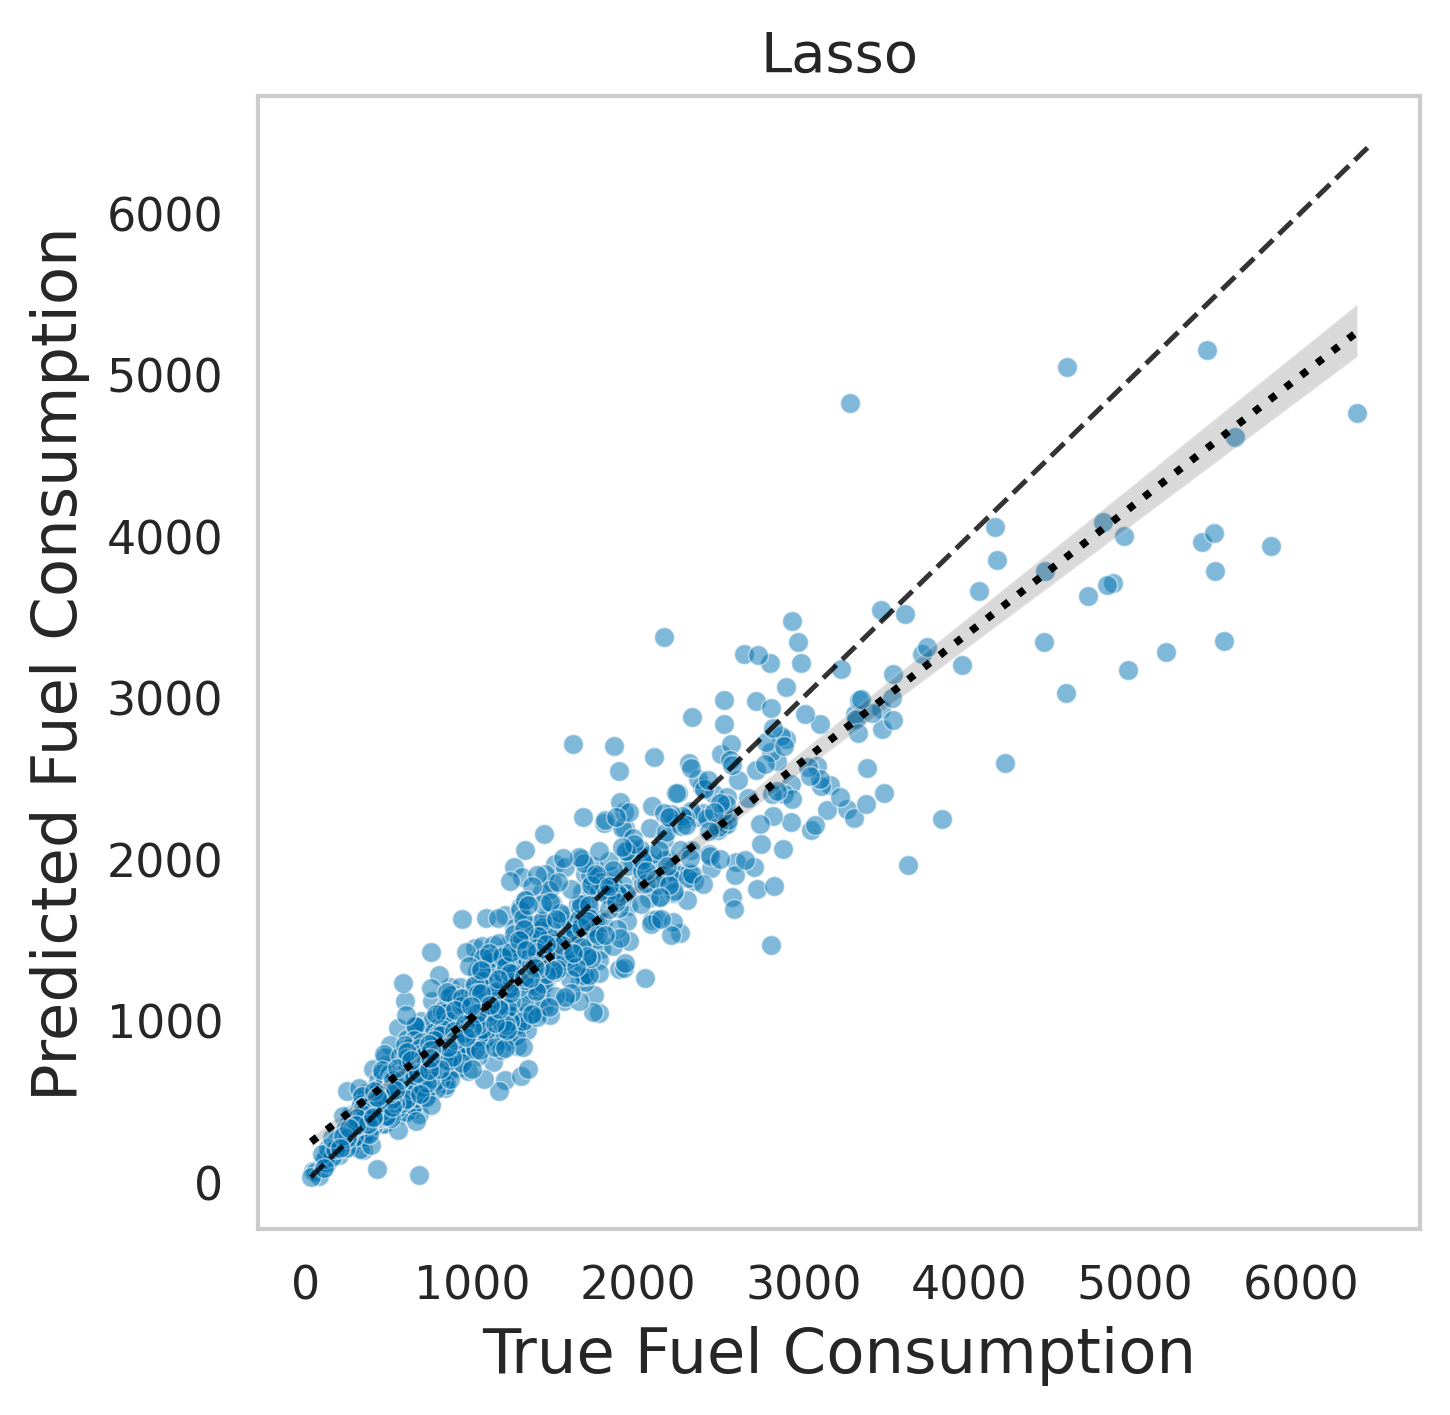

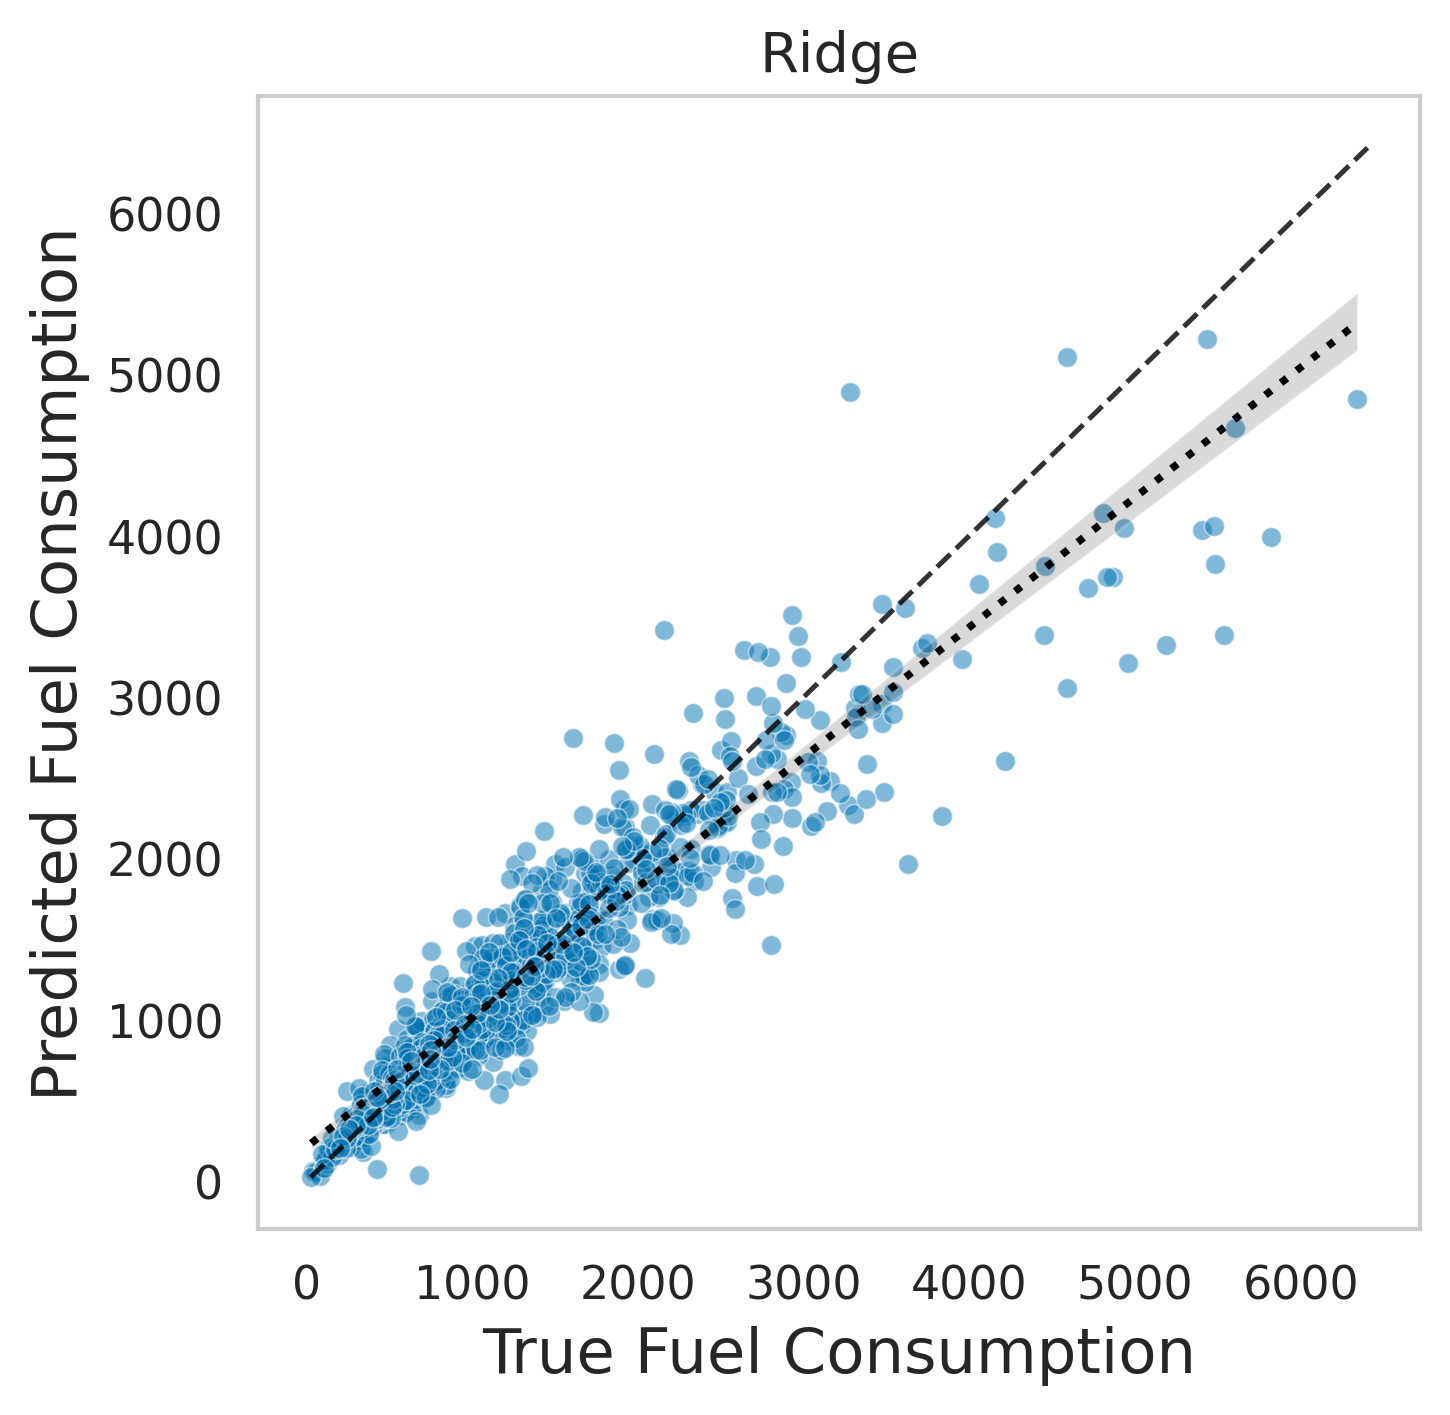

model
gb        None
linear    None
lasso     None
ridge     None
dtype: object

In [181]:
mdl_df.apply(lambda row: two_way_plot(y, row['train_prediction'], title=row['name'], xlabel='True Fuel Consumption', ylabel='Predicted Fuel Consumption', regline=True, legend=False), axis=1)

### Feature Importance

#### Permutation-based

In [182]:
mdl_df['perm_importance'] = mdl_df.apply(lambda row: permutation_importance(
    row['best_estimator'],
    X[features],
    y,
    n_repeats=10,
    random_state=0,
    n_jobs=max_cores),
    axis=1)

#### Plots

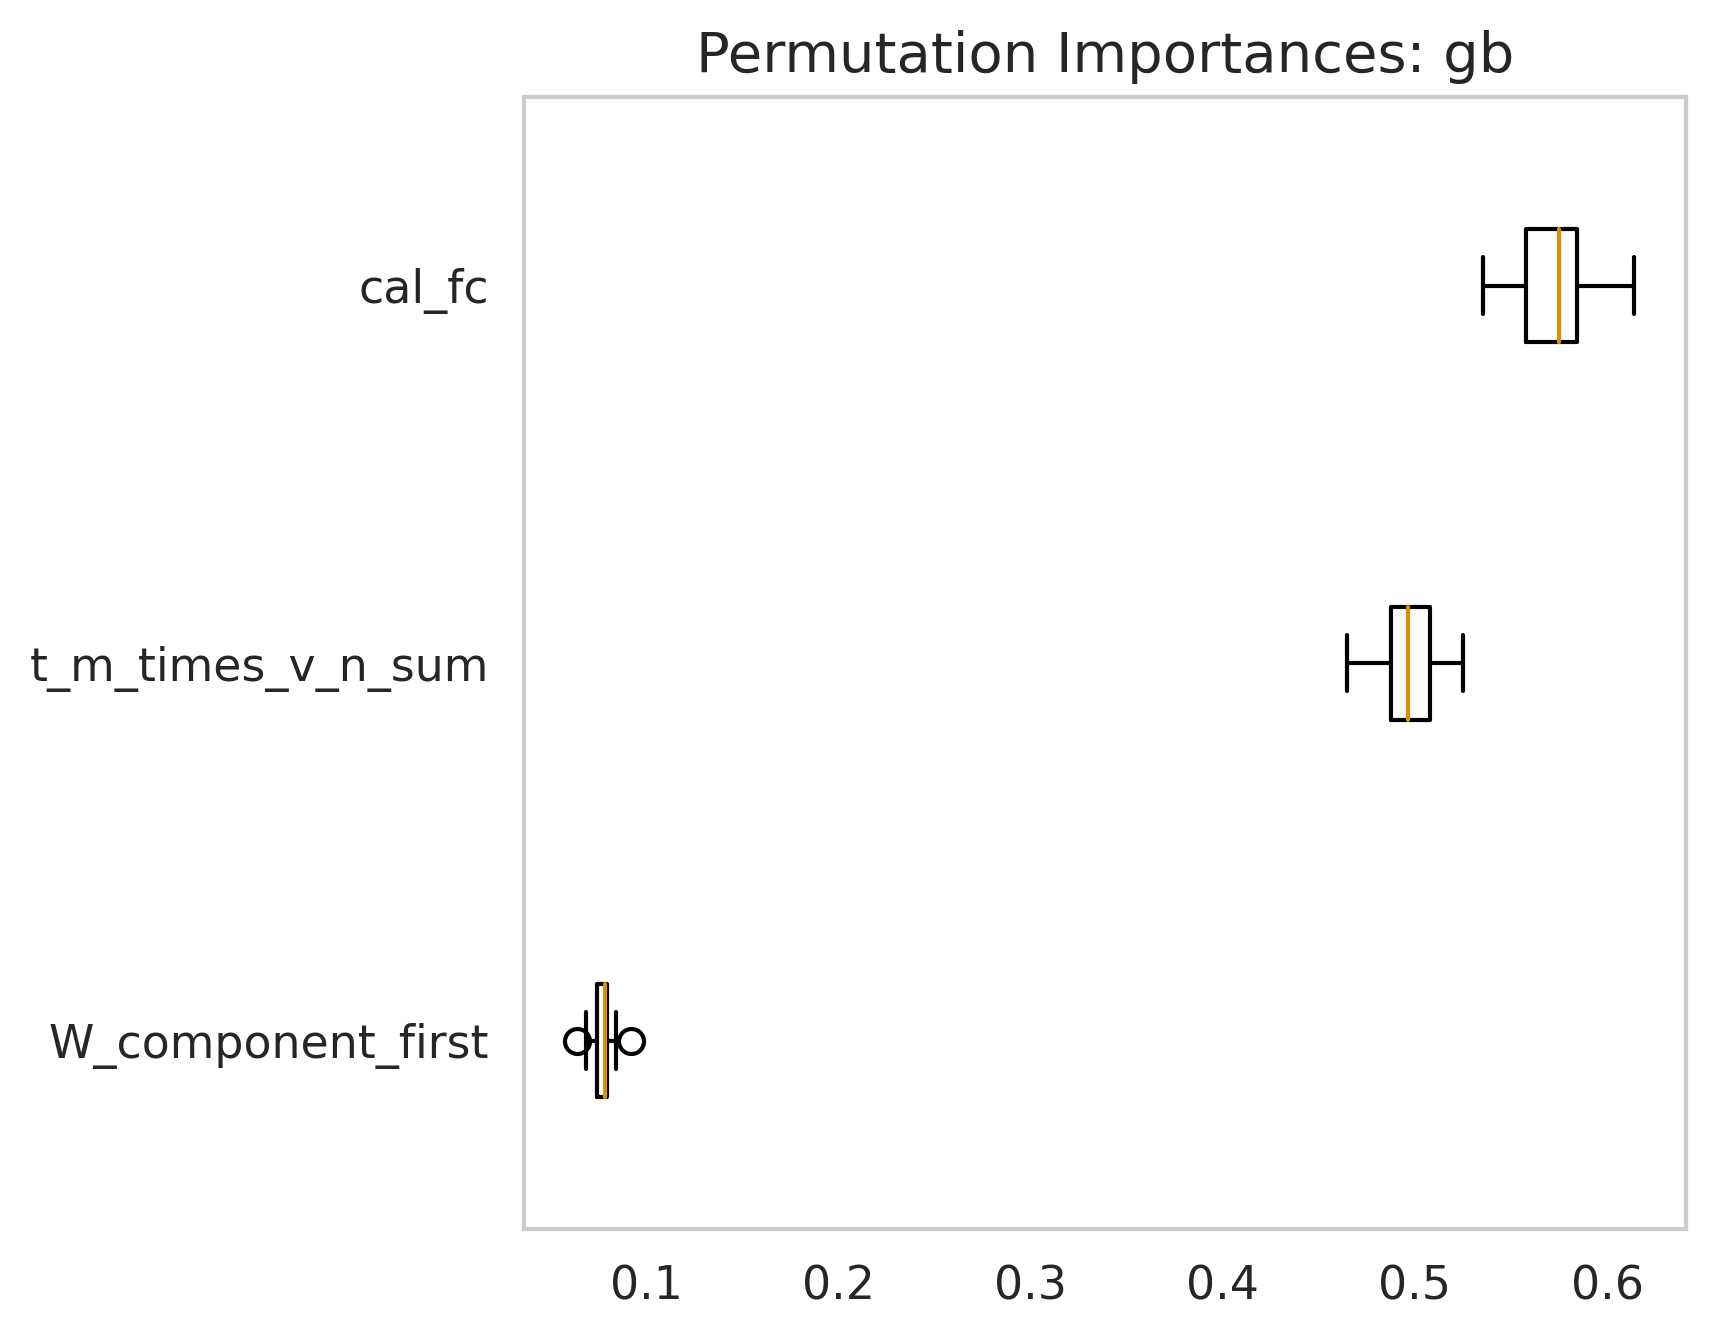

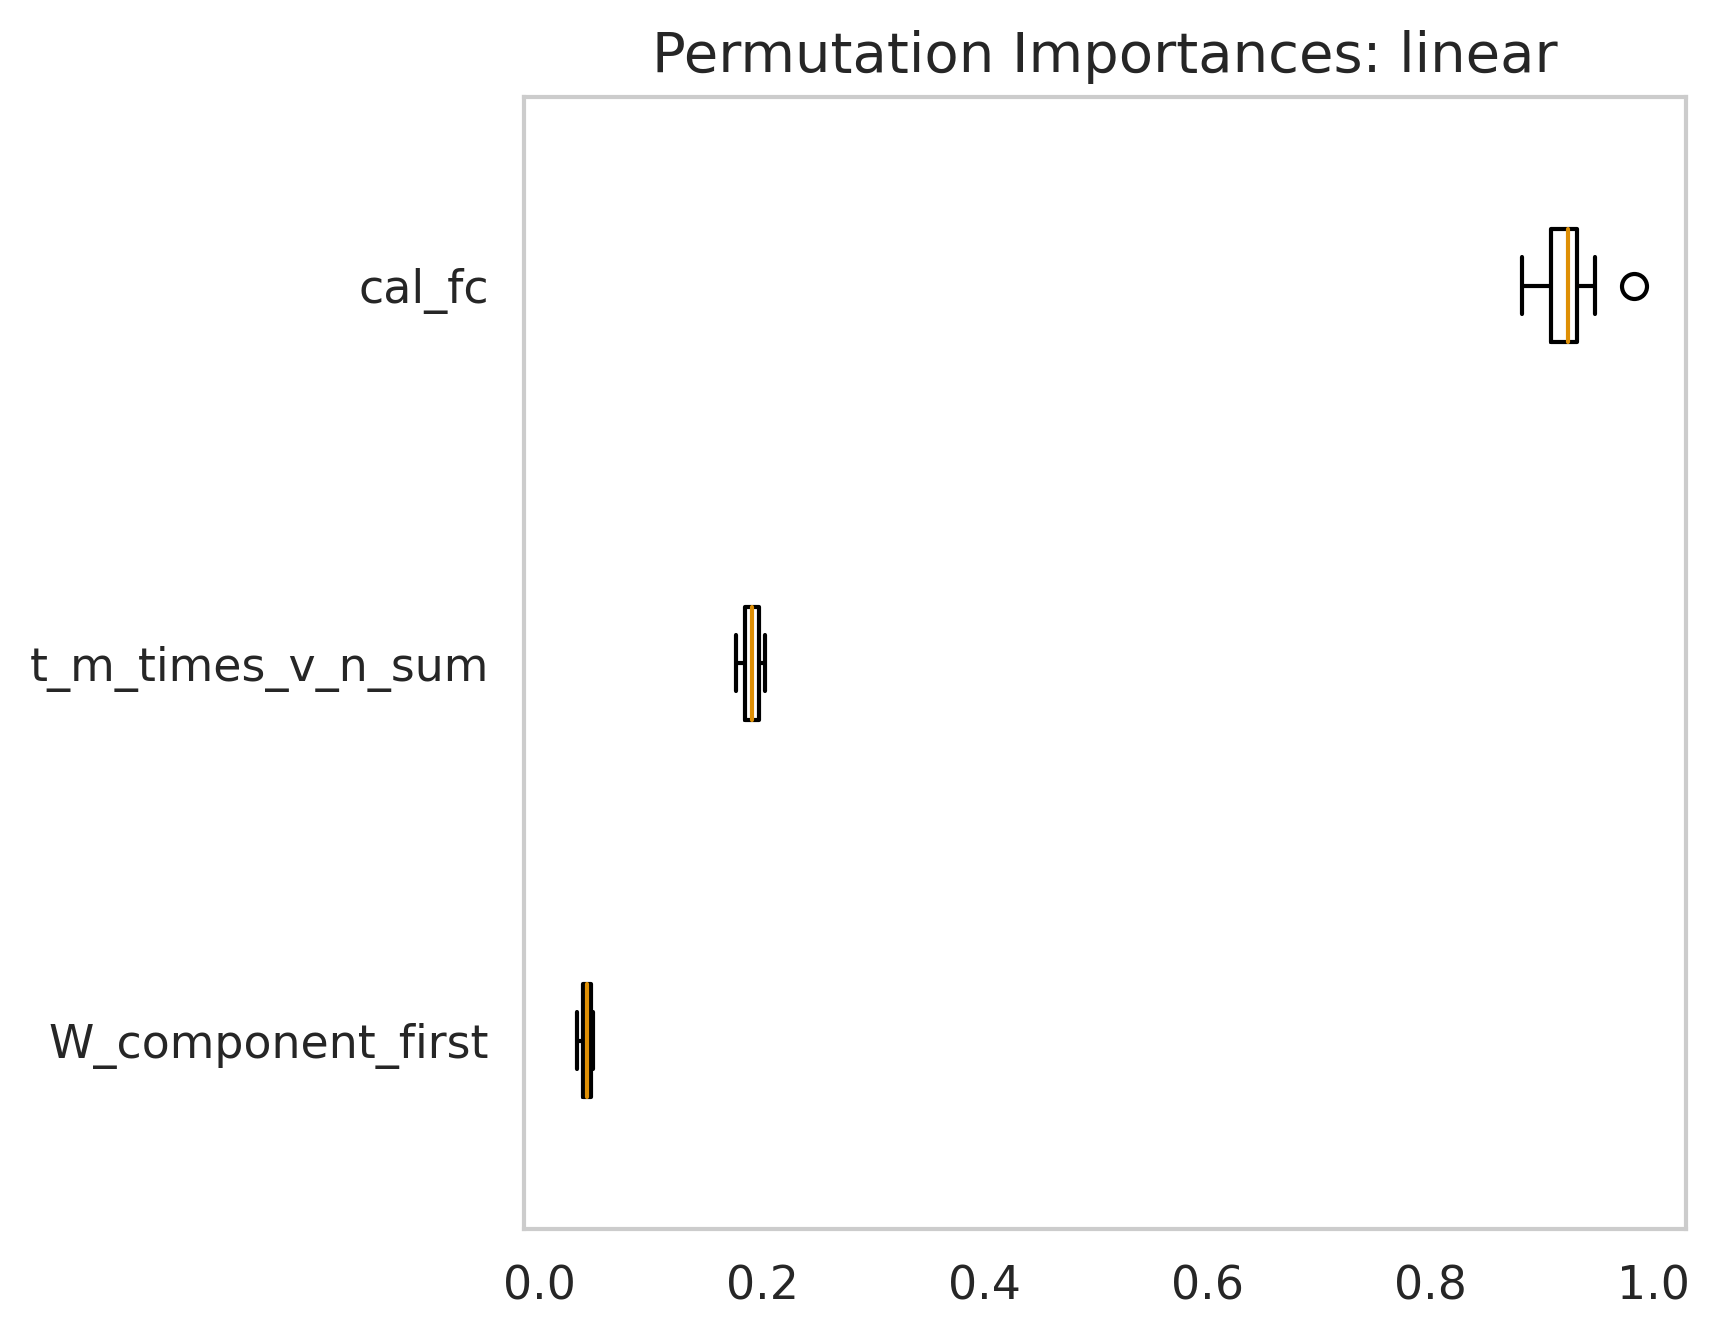

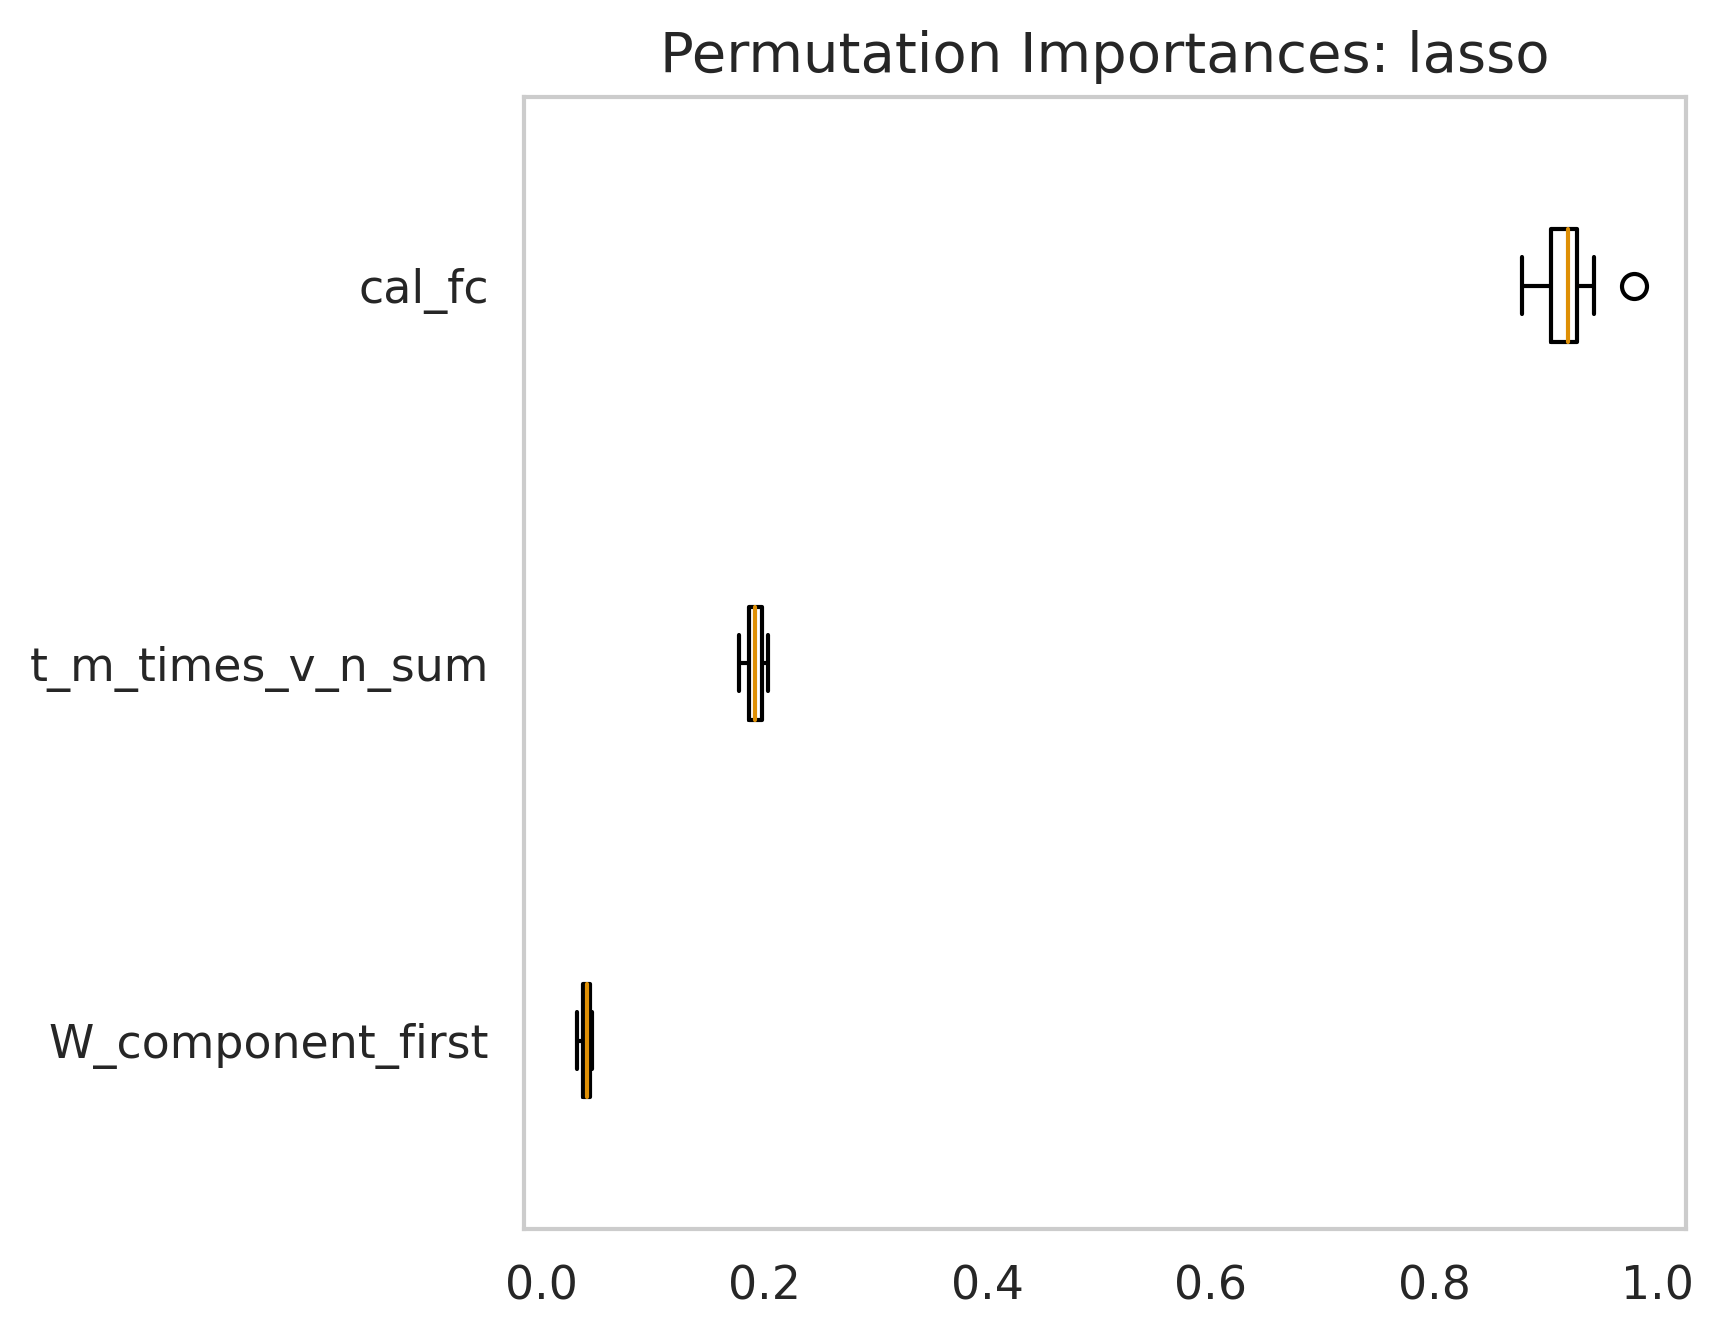

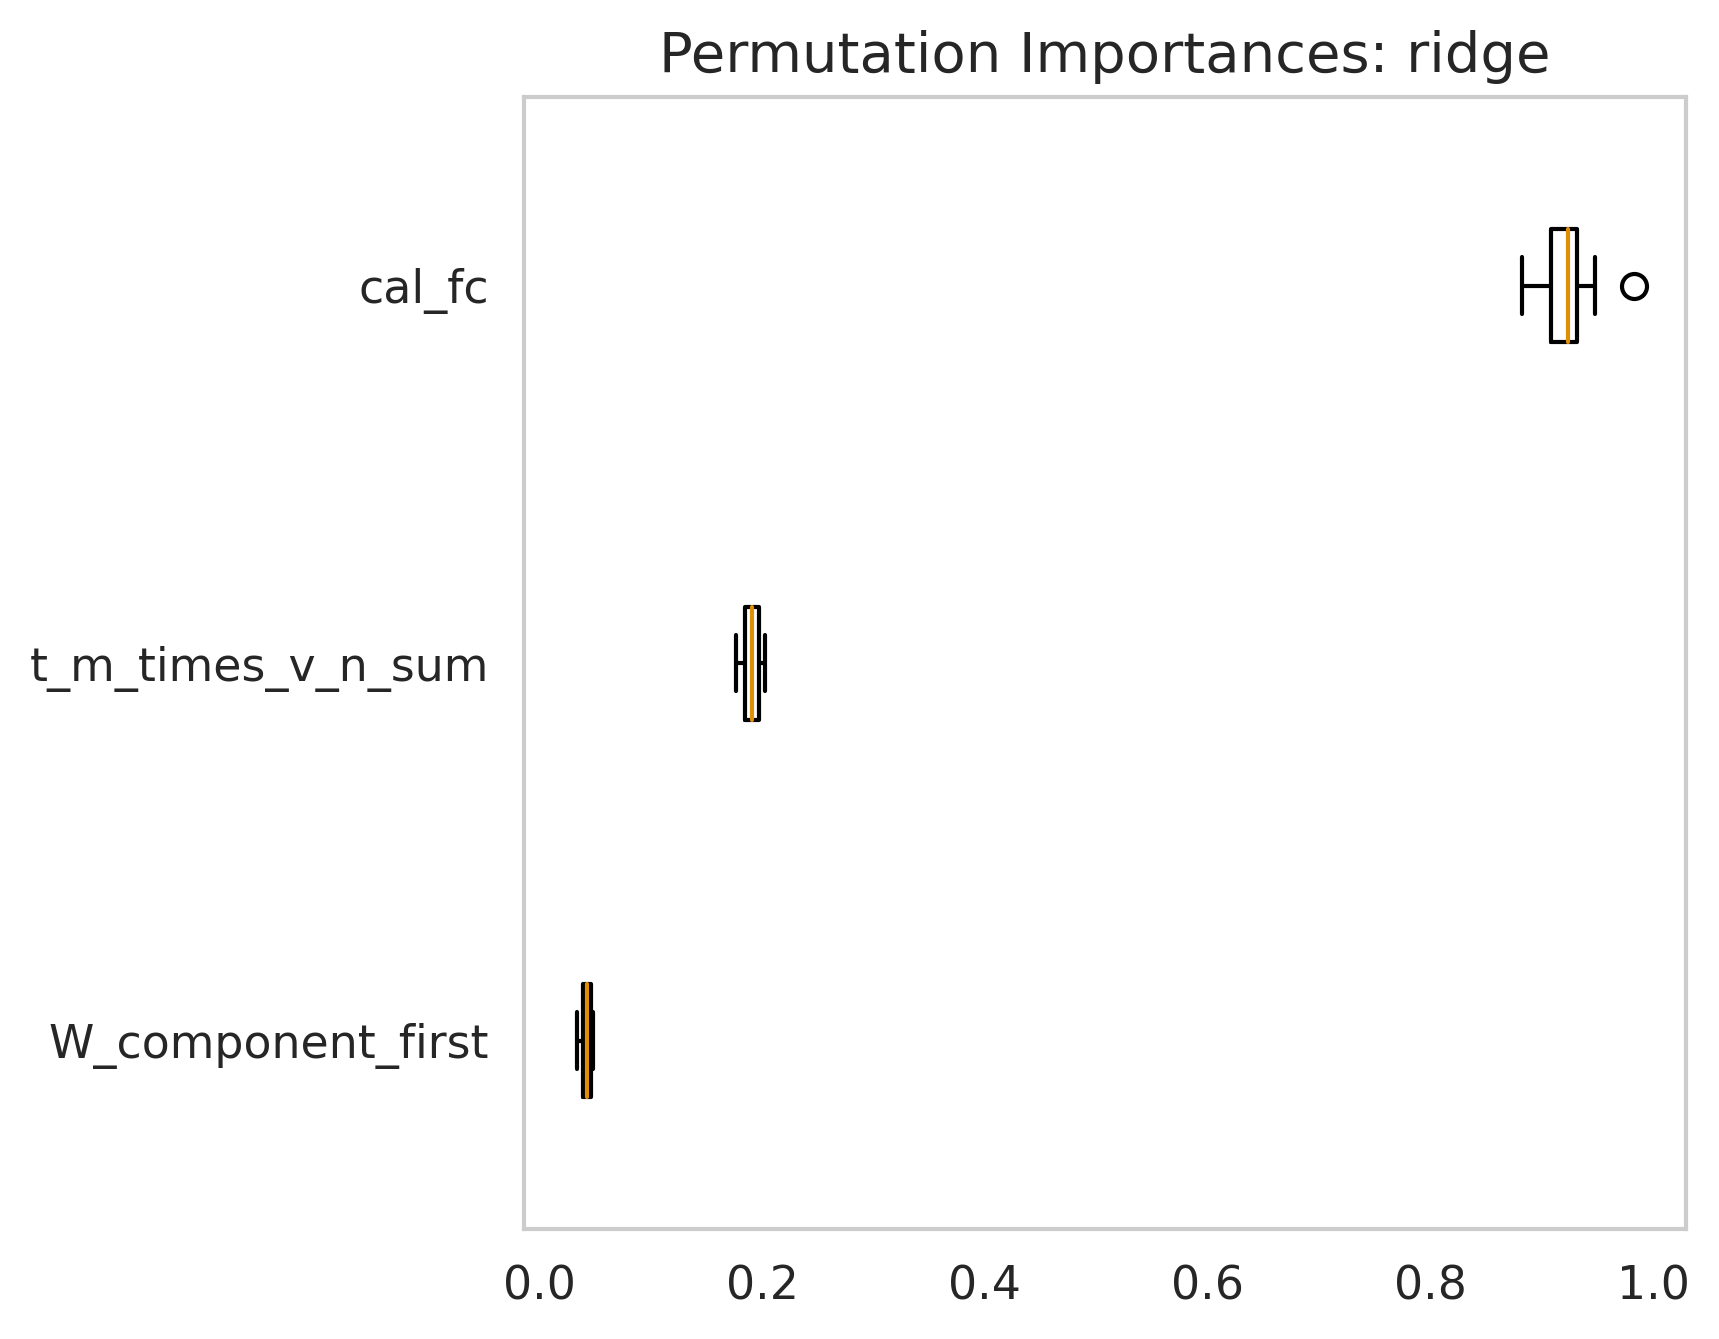

In [183]:
for model in mdl_df.index:
    FI_plot(mdl_df.loc[model, 'perm_importance'], model)

### Rank

In [184]:
FI_df = pd.DataFrame()
for model in mdl_df.index:
    FI_df = pd.concat([FI_df, pd.DataFrame(mdl_df.loc[model, 'perm_importance']['importances_mean'], columns = ['importance'], index = features).assign(model = model)], axis=0)

FI_df['rank'] = FI_df.groupby('model')['importance'].rank(ascending=False).astype(int)
FI_df = FI_df.drop(columns='importance').pivot(columns='model', values='rank')
FI_df['mean'] = FI_df.mean(axis=1)
FI_df['sd'] = FI_df.std(axis=1)
FI_df = FI_df.sort_values('mean')
FI_df.to_csv(trackeddatapath + fileprefix + 'FI.csv')
FI_df


model,gb,lasso,linear,ridge,mean,sd
cal_fc,1,1,1,1,1.0,0.0
t_m_times_v_n_sum,2,2,2,2,2.0,0.0
W_component_first,3,3,3,3,3.0,0.0


In [185]:
print(f"Evaluation complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

Evaluation complete at 2024-04-25 18:03:54, after 1.2 minutes


## Test Data

### Load, explore, filter

In [186]:
# df_ml_test = pd.read_csv(readdatapath + "df_ml_" + tol_type + "_test.csv", low_memory=False)
df_ml_test = df_ml_raw.loc[eval(test_exp)]

# for nicer colors when plotting
df_ml_test = df_ml_test.sort_values('year')
df_ml_test['year_str'] = df_ml_test['year'].astype(str) 

# Create OECD variable
df_ml_test['cubic_meter'] = df_ml_test['Beam.Mld..m.']*df_ml_test['Depth.Moulded..m.']*df_ml_test['LOA..m.']

# Label as outliers according *training* set thresholds
df_ml_test['outlier'] = ~df_ml_test['residual'].between(
    raw_mean - outlier_threshold * raw_std,
    raw_mean + outlier_threshold * raw_std,
    inclusive='neither')

# df_ml_test.describe(include='all')

In [187]:
df_ml_test = df_ml_test.loc[~df_ml_test['outlier']]
print(f'Filtered Data: \n observations: {len(df_ml)} \n target mean: {df_ml_test.residual.mean()} \n target sd: {df_ml_test.residual.std()}')

Filtered Data: 
 observations: 1133 
 target mean: 0.022420185265642663 
 target sd: 0.2601301020222977


## Test set performance

In [188]:
stats_eng_test = calculate_stats('report_fc', 'cal_fc', df_ml_test, validation_stats)
stats_eng_test_df = pd.DataFrame(stats_eng_test).drop('names', axis=1).T
stats_eng_test_df['model'] = 'eng'
stats_eng_test_df['class_name'] = 'Calculation'
stats_eng_test_df = stats_eng_test_df.set_index('model')

mdl_df['test_prediction'] = mdl_df.apply(lambda row: row['best_estimator'].predict(df_ml_test), axis=1)


mdl_df['test_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        df_ml_test.report_fc,
        row['test_prediction'],
        stats_dict=validation_stats),
    axis=1)
compare_test_fc_df = model_stats_comparison_table('test_fc_stats', 'best_params', 'best_estimator', mdl_df)
compare_test_fc_df = pd.concat([stats_eng_test_df, compare_test_fc_df], axis=0).sort_values('r2', ascending=False)

compare_test_fc_df.to_csv(trackeddatapath + fileprefix + 'test_fc.csv')
compare_test_fc_df

,r2,mse,mae,mape,class_name,params
model,,,,,,
ridge,0.905942,83708.044700,189.579841,0.164150,Ridge,{'alpha': 0.005}
linear,0.905941,83708.886019,189.580706,0.164151,LinearRegression,{}
lasso,0.903602,85790.590220,190.809778,0.164942,Lasso,{'alpha': 0.005}
gb,0.897757,90992.206140,190.356197,0.163079,GradientBoostingRegressor,"{'learning_rate': 0.005, 'max_depth': 3}"
eng,0.699965,267020.160507,245.821387,0.195241,Calculation,NaN


### Plot best vs. calc

In [189]:
models_to_compare = {'ridge':'Ridge', 'eng': 'Calculation'}
predictions_df = pd.DataFrame(columns=['model', 'predict_fc', 'report_fc'])
for model, name in models_to_compare.items():
    if model == 'eng':
        model_df = pd.DataFrame({'predict_fc': df_ml_test['cal_fc'],
                                 'report_fc': df_ml_test['report_fc']})
    else:
        model_df = pd.DataFrame({'predict_fc': mdl_df.loc[model, 'test_prediction'],
                                 'report_fc': df_ml_test['report_fc']})
    model_df['model'] = name
    predictions_df = pd.concat([predictions_df, model_df],
                               ignore_index=True)
predictions_df = predictions_df.set_index('model')

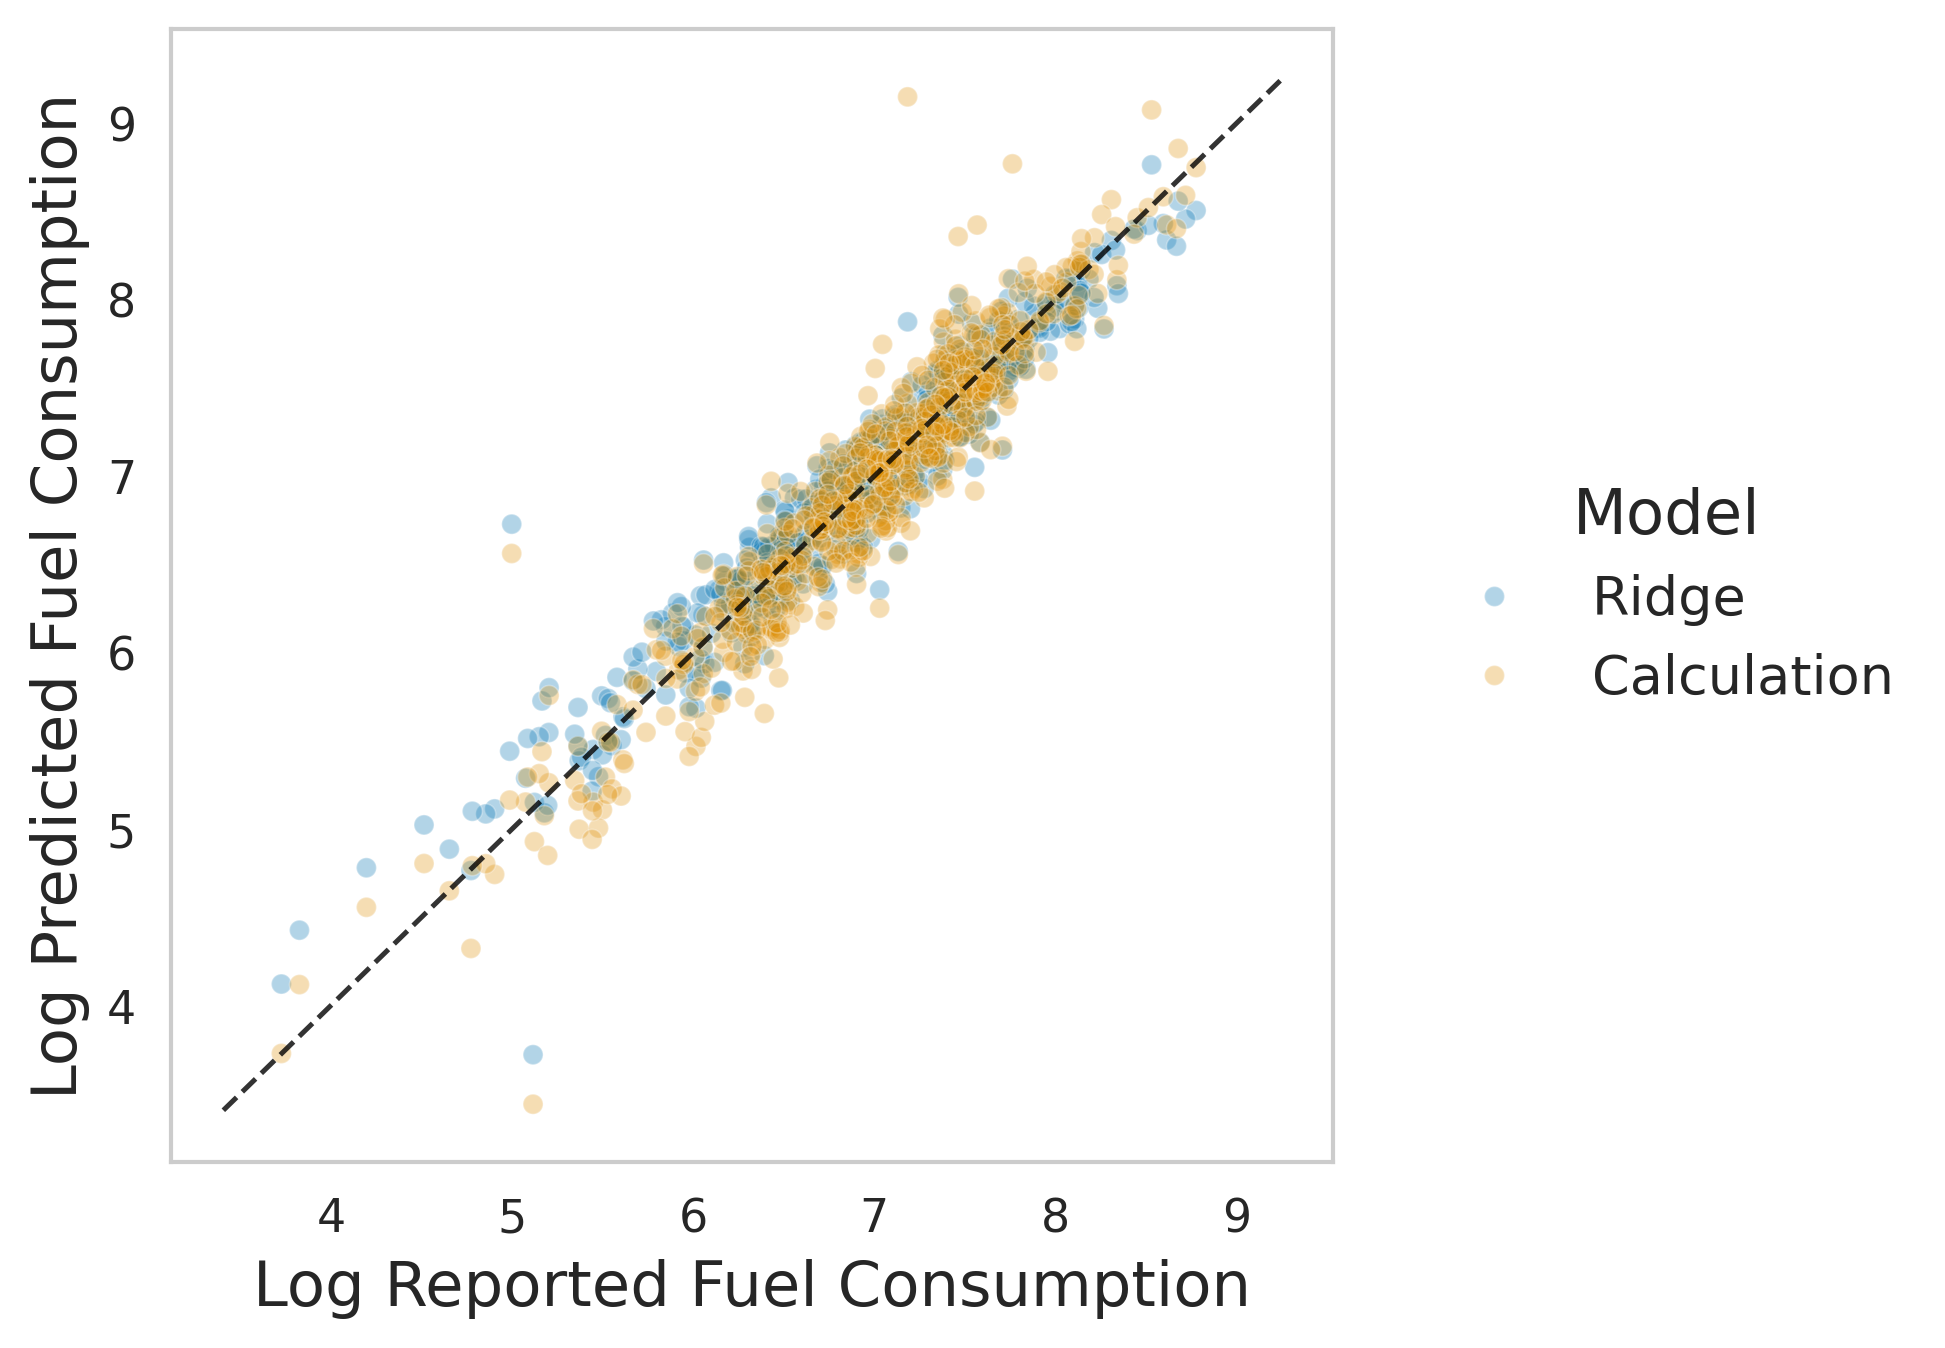

In [190]:
try: 
     two_way_plot(
          'report_fc',
          'predict_fc',
          np.log1p(predictions_df),
          hue='model',
          alpha=0.3,
     #  title='Test',
          xlabel='Log Reported Fuel Consumption',
          ylabel='Log Predicted Fuel Consumption',
          legend=True,
          legend_title='Model',
          regline=False,
          savepath=plotpath + fileprefix + 'twoway_test_logs_bestvscalc.png')
except:
     print('except')
     two_way_plot(
          'report_fc',
          'predict_fc',
          np.log1p(predictions_df.loc[predictions_df['predict_fc'] >= 0]),
          hue='model',
          alpha=0.3,
          title='Negative values dropped',
          xlabel='Log Reported Fuel Consumption',
          ylabel='Log Predicted Fuel Consumption',
          legend=True,
          legend_title='Model',
          regline=False,
          savepath=plotpath + fileprefix + 'twoway_test_logs_bestvscalc.png')

### Permutation Importance

In [191]:
mdl_df['perm_importance_test'] = mdl_df.apply(lambda row: permutation_importance(
    row['best_estimator'],
    df_ml_test[features],
    df_ml_test.report_fc,
    n_repeats=10,
    random_state=0,
    n_jobs=max_cores),
    axis=1)

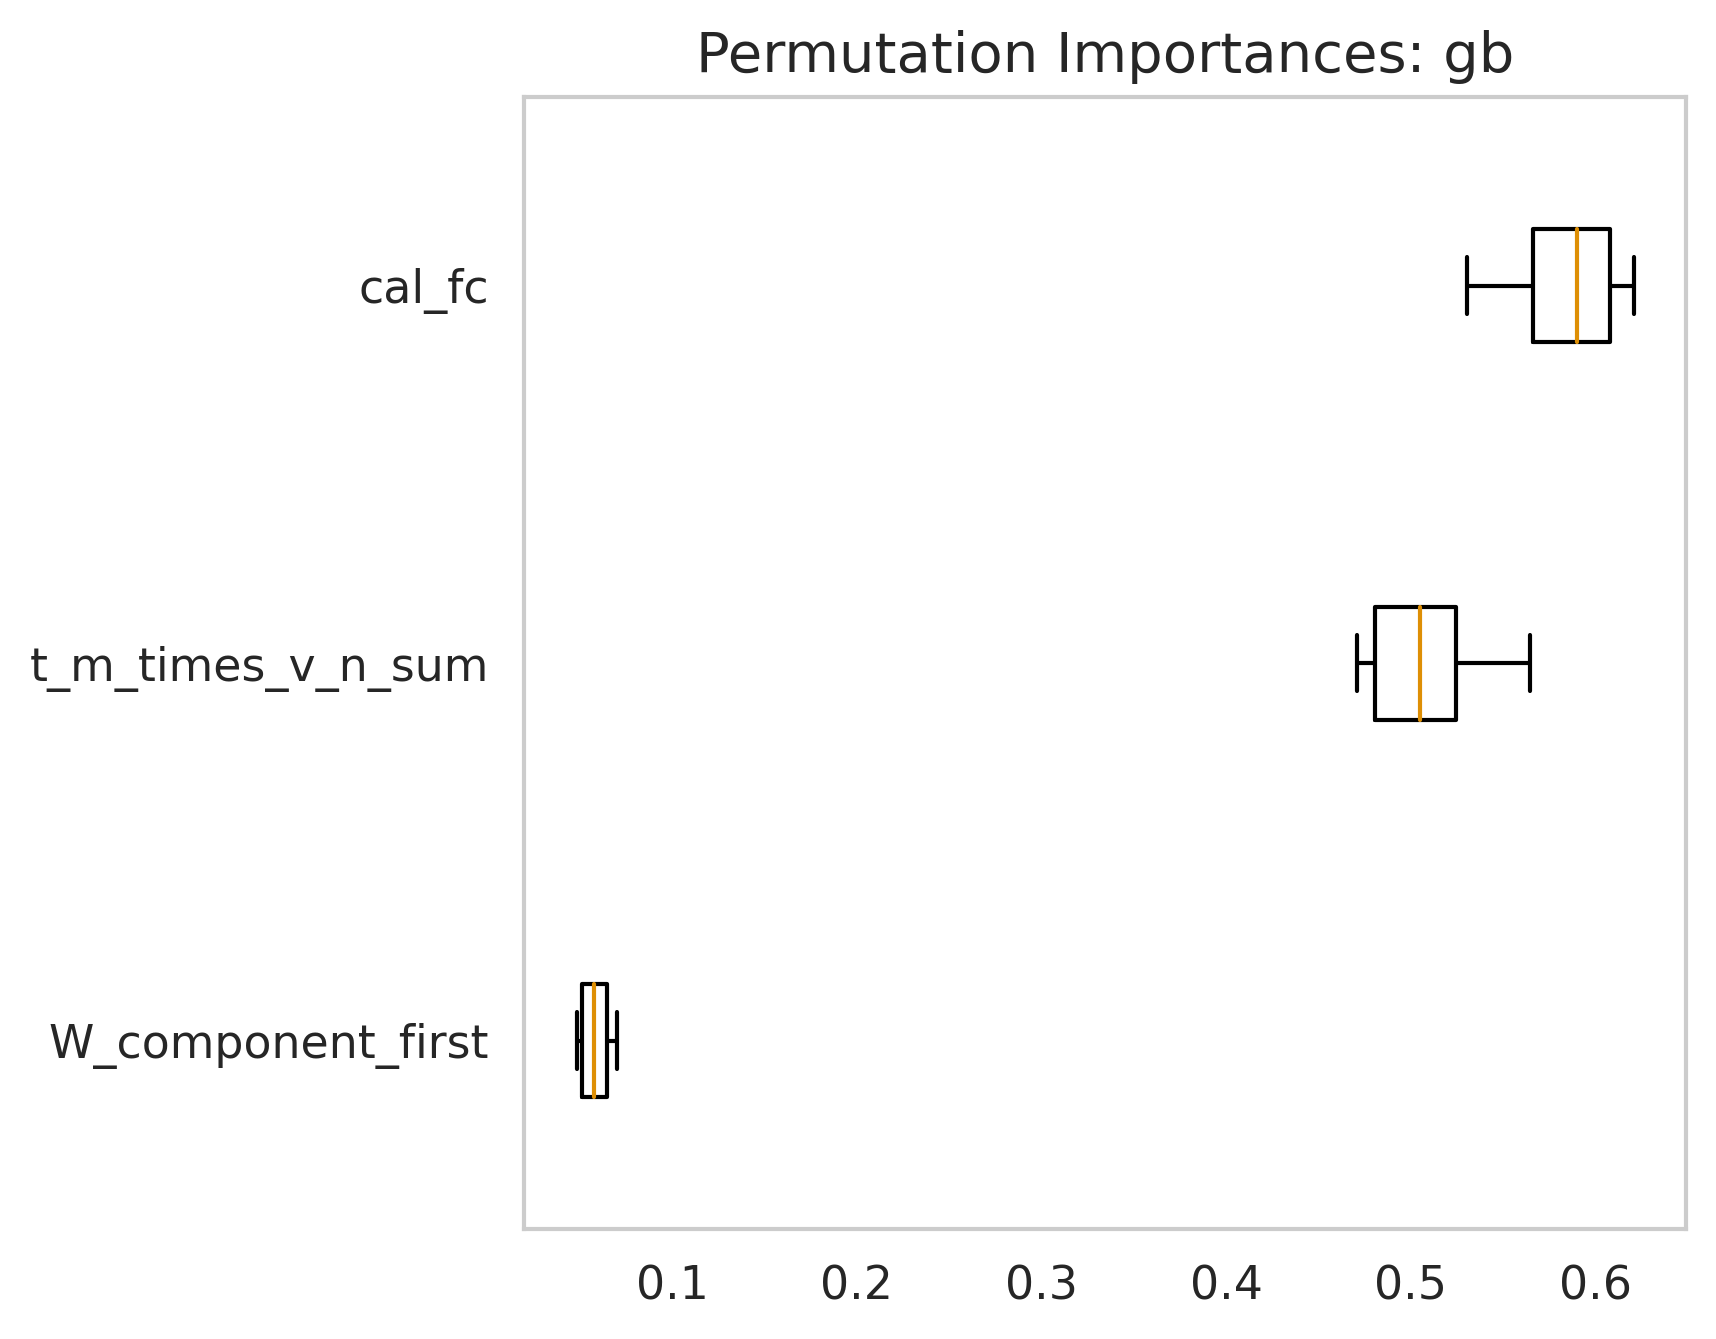

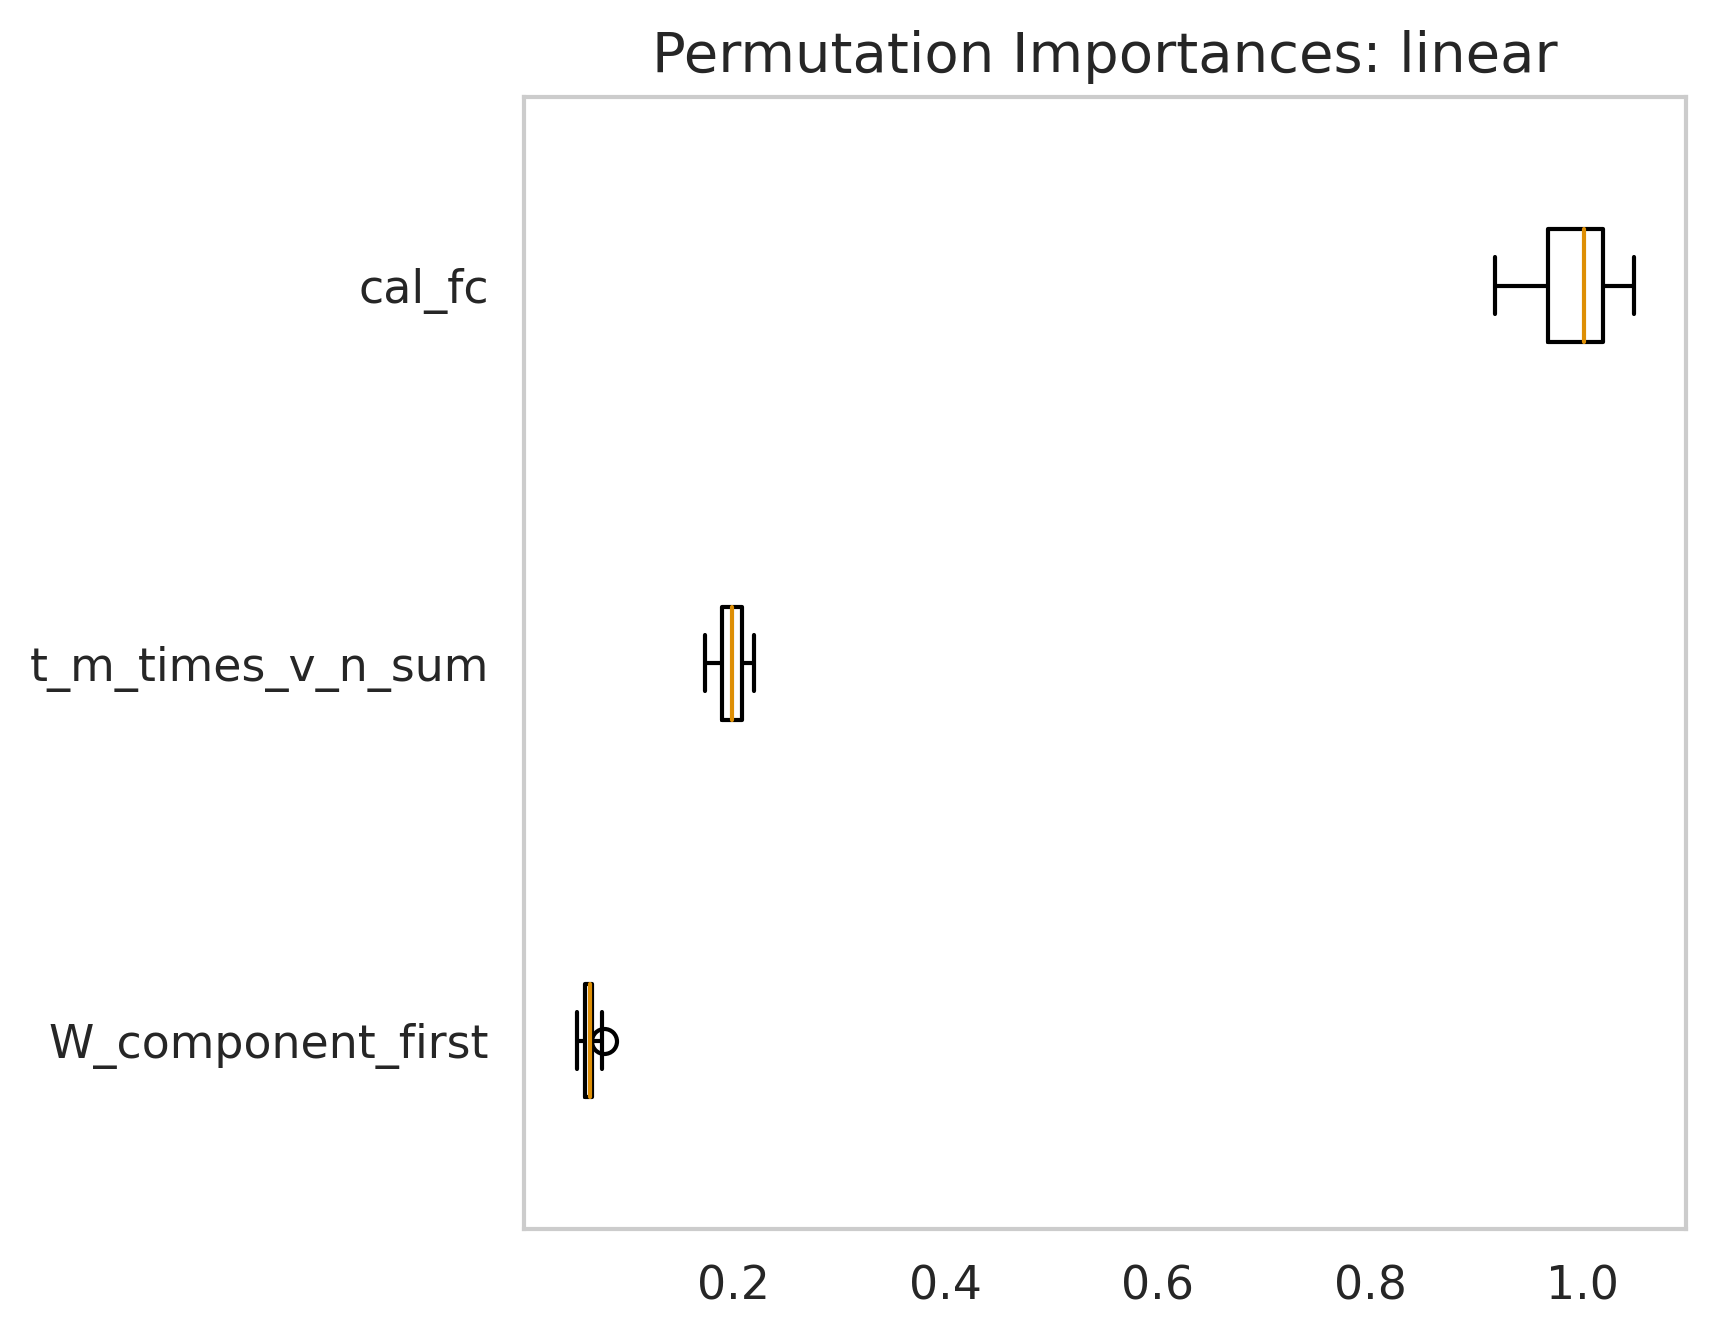

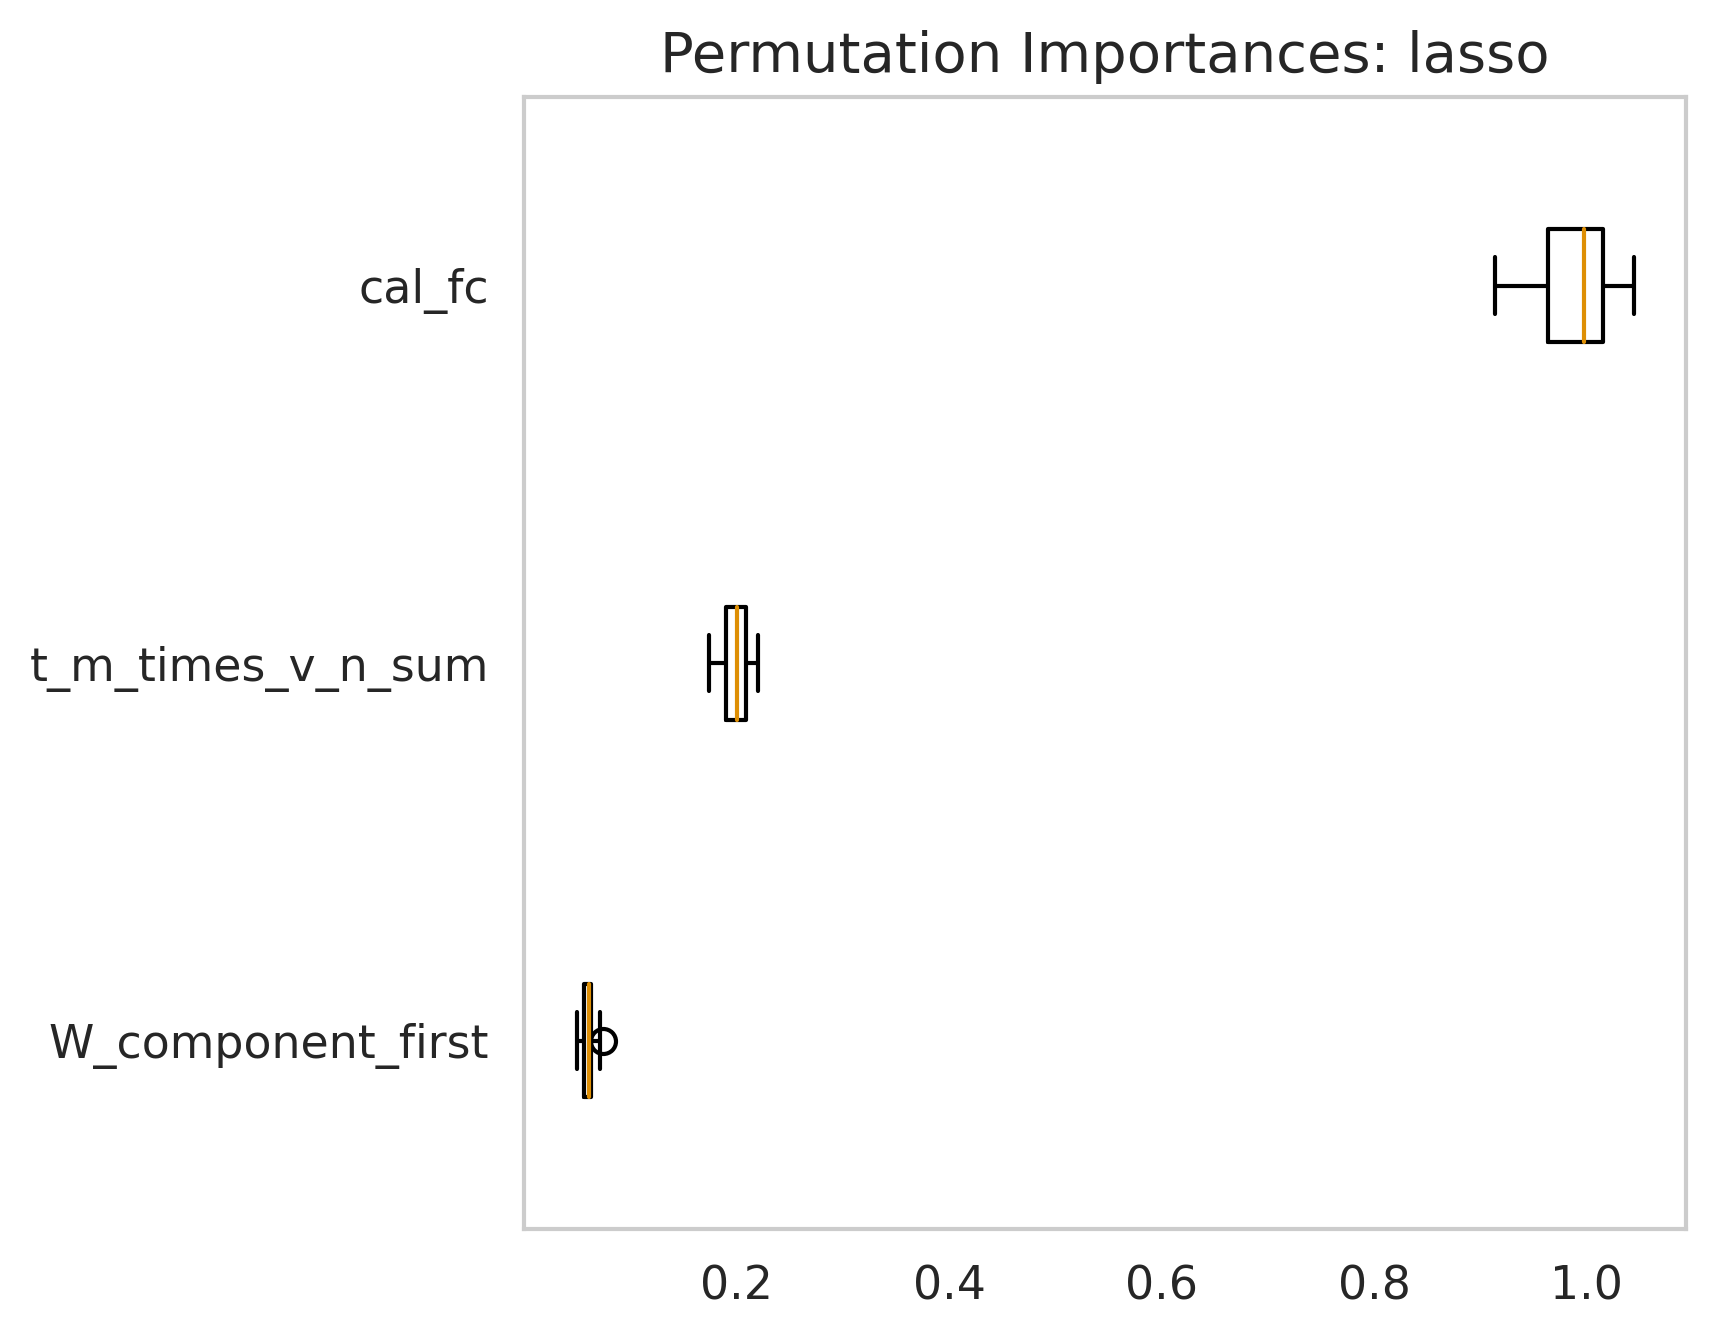

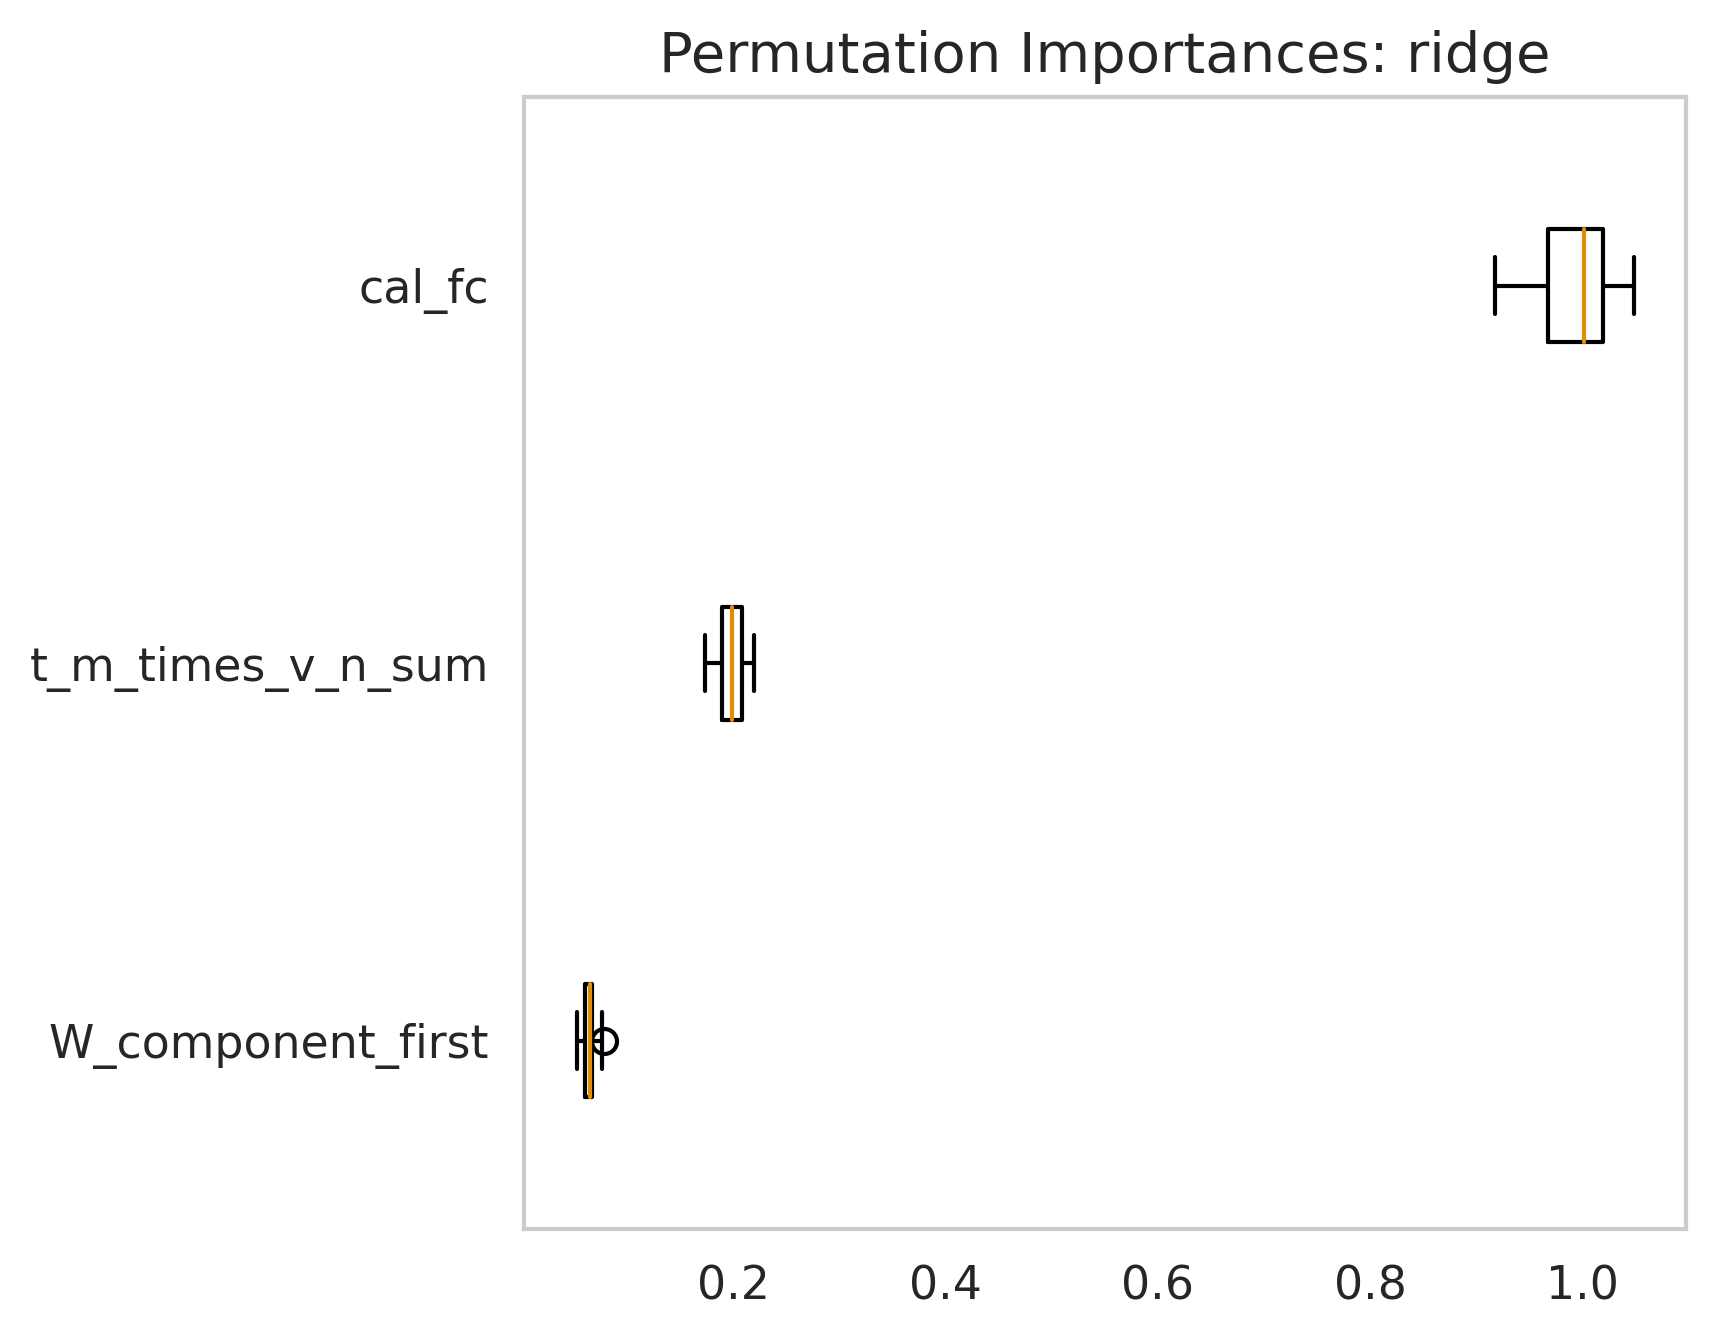

In [192]:
for model in mdl_df.index:
    FI_plot(mdl_df.loc[model, 'perm_importance_test'], model)

In [193]:
FI_df = pd.DataFrame()
for model in mdl_df.index:
    FI_df = pd.concat([FI_df, pd.DataFrame(mdl_df.loc[model, 'perm_importance_test']['importances_mean'], columns = ['importance'], index = features).assign(model = model)], axis=0)

FI_df['rank'] = FI_df.groupby('model')['importance'].rank(ascending=False).astype(int)
FI_df = FI_df.drop(columns='importance').pivot(columns='model', values='rank')
FI_df['mean'] = FI_df.mean(axis=1)
FI_df['sd'] = FI_df.std(axis=1)
FI_df = FI_df.sort_values('mean')
FI_df.to_csv(trackeddatapath + fileprefix + 'FI_test.csv')
FI_df

model,gb,lasso,linear,ridge,mean,sd
cal_fc,1,1,1,1,1.0,0.0
t_m_times_v_n_sum,2,2,2,2,2.0,0.0
W_component_first,3,3,3,3,3.0,0.0


In [194]:
print(f"Totally complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

Totally complete at 2024-04-25 18:03:58, after 1.3 minutes


## Aggregate Fuel Consumption

In [195]:
df_ml_all = pd.concat([df_ml, df_ml_test], keys=['Training', 'Test'])
df_ml_all.reset_index(level=0, inplace=True)
df_ml_all.rename(columns={'level_0': 'set'}, inplace=True)

In [196]:
mdl_df['total_fc_predictions'] = mdl_df.apply(lambda row: agg_prediction_by_year(row['best_estimator'], df_ml_all), axis=1)

# mdl_df['total_fc_predictions']
total_fc_predictions_df = pd.DataFrame()
for model in mdl_df.index:
    total_fc_predictions_df = pd.concat([total_fc_predictions_df, mdl_df.loc[model, 'total_fc_predictions'].assign(model=model)], axis=0)

total_fc_cal_df = (
    df_ml_all
    .groupby('year')[['cal_fc', 'report_fc']]
    .agg(sum)
    .rename(columns={'cal_fc': 'eng', 'report_fc' : 'report'})
    .reset_index()
    .melt(id_vars='year', var_name='model', value_name='predict_fc_total')
    .set_index('year'))
total_fc_cal_df

,model,predict_fc_total
year,,
2019,eng,659697.694150
2020,eng,802541.858151
2021,eng,879497.233689
2019,report,676405.220000
2020,report,803348.830000
2021,report,857909.680000


In [197]:
total_fc_predictions_df = pd.concat([total_fc_predictions_df, total_fc_cal_df])
total_fc_predictions_df

,predict_fc_total,model
year,,
2019,650800.372277,gb
2020,801552.816839,gb
2021,854049.977293,gb
2019,642127.595597,linear
2020,790944.399558,linear
2021,850937.740381,linear
2019,640208.702795,lasso
2020,788441.032614,lasso
2021,847847.672406,lasso


### Total FC table

In [198]:
total_fc_predictions_tbl = total_fc_predictions_df.reset_index().pivot(index='model', columns='year', values='predict_fc_total')
total_fc_predictions_tbl.to_csv(trackeddatapath + fileprefix + 'total_fc.csv', index=True)

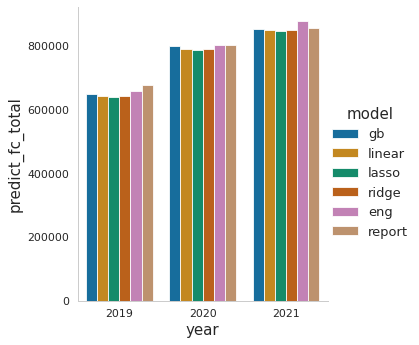

In [199]:
sns.catplot(
    data=total_fc_predictions_df, kind="bar",
    x="year", y="predict_fc_total", hue="model",
    errorbar=None
)